#  KPMG Virtual Intership Data Analysis 

In [45]:
# import libraries for data manipulation
import numpy as np
import pandas as pd

# import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
import matplotlib.cm as cm
%matplotlib inline

#k-means
import yellowbrick
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# K-Medoids
from sklearn_extra.cluster import KMedoids

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

import warnings
import os
from IPython.display import display
warnings.filterwarnings('ignore')


### Reading Data

In [46]:
transactions = pd.read_excel(r"KPMG.xlsx", sheet_name='Transactions', header=1)
cus_demographic = pd.read_excel(r"KPMG.xlsx", sheet_name='CustomerDemographic', header=1)
cust_address = pd.read_excel(r"KPMG.xlsx", sheet_name='CustomerAddress', header=1)
new_cust = pd.read_excel(r"KPMG.xlsx", sheet_name='NewCustomerList', header=1)

### Data Cleaning

Data is being cleaned according to the findings in the Data Quality Assesment in Task 1

In [47]:
#Transactions Data
# dropping inconsistent values
transactions.dropna(inplace=True) #dropping null values
transactions.drop('product_first_sold_date', axis=1, inplace=True) #dropping inconsistent column

# data transformation
transactions.transaction_id = transactions.transaction_id.astype(str)
transactions.product_id = transactions.product_id.astype(str)
transactions.customer_id = transactions.customer_id.astype(str)

In [48]:
# Customer Demographic Data
# data transformation
cus_demographic.customer_id = cus_demographic.customer_id.astype(str)
cus_demographic['DOB'] = pd.to_datetime(cus_demographic['DOB'])

# dropping inconsistent values
cus_demographic.drop('default', axis=1, inplace=True) 
cus_demographic = cus_demographic.loc[cus_demographic['DOB'].dt.year != 1843] 

# replace values
cus_demographic['gender'] = cus_demographic['gender'].replace('F', 'Female').replace('M','Male').replace('Femal','Female').replace('U','Unidentified') 

In [49]:
# missing data
# NaN numerical value replace with median value: 'ternure'.
median_tenure = cus_demographic.tenure.median()
cus_demographic.tenure.fillna(median_tenure, inplace=True)

# NaN categorical values replace with mode value: 'DOB', 'job_title', 'job_industry_category'.
columns = ['DOB','job_title', 'job_industry_category']

for column in columns:
    mode_value = cus_demographic[column].mode()[0]
    cus_demographic[column].fillna(mode_value, inplace=True)

# 'last_name' replace with 'Unknown' 
cus_demographic.last_name = cus_demographic.last_name.fillna('Unknown')

In [50]:
#Customer Address Data
# replace values
cust_address['state'] = cust_address['state'].replace('VIC', 'Victoria').replace('NSW', 'New South Wales')

# data transformation
cust_address.customer_id = cust_address.customer_id.astype(str)

In [51]:
#New Customer Data
# dropping inconsistent values
new_cust = new_cust.drop(['Unnamed: 16','Unnamed: 17','Unnamed: 18','Unnamed: 19','Unnamed: 20'], axis=1)

# replace values
new_cust['gender'] = new_cust['gender'].replace('U', 'Unidentified')

# data transformation
new_cust['DOB'] = pd.to_datetime(new_cust['DOB'])

In [52]:
# missing data
# NaN categorical values replace with mode value: 'DOB', 'job_title', 'job_industry_category'.
columns = ['DOB','job_title', 'job_industry_category']

for column in columns:
    mode_value = new_cust[column].mode()[0]
    new_cust[column].fillna(mode_value, inplace=True)

# 'last_name' replace with 'Unknown' 
new_cust.last_name = new_cust.last_name.fillna('Unknown')

### Data Integration

**Merging:** <br>
to make data uniform let's merge Old Customer's tables: Customer Demographic and Customer Address

In [53]:
old_cust = pd.merge(cus_demographic, cust_address, on='customer_id')
old_cust.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,DOB,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation
0,1,Laraine,Medendorp,Female,93,1953-10-12,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,New South Wales,Australia,10
1,2,Eli,Bockman,Male,81,1980-12-16,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,New South Wales,Australia,10
2,4,Talbot,Unknown,Male,33,1961-10-03,Business Systems Development Analyst,IT,Mass Customer,N,No,7.0,0 Holy Cross Court,4211,QLD,Australia,9
3,5,Sheila-kathryn,Calton,Female,56,1977-05-13,Senior Editor,Manufacturing,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,New South Wales,Australia,4
4,6,Curr,Duckhouse,Male,35,1966-09-16,Business Systems Development Analyst,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,Victoria,Australia,9


In [54]:
old_cust.shape

(3995, 17)

In [55]:
#To make this anaysis more precise we will only count the approved transactions, therefore we are dropping the 172 cancelled orders
transactions.order_status.value_counts()

order_status
Approved     19273
Cancelled      172
Name: count, dtype: int64

In [56]:
transactions = transactions.loc[transactions['order_status'] != 'Cancelled']

In [57]:
#Transforming DOB TO Age 
# Age column
#age in 2017 since that was the time that the program was launched
age_in_2017 = 2017 - old_cust['DOB'].dt.year
old_cust['age'] = age_in_2017

age_in_2017 = 2017 - new_cust['DOB'].dt.year
new_cust['age'] = age_in_2017

#Dropping DOB column because no longer necessary
old_cust.drop(columns=['DOB'], inplace=True)
new_cust.drop(columns=['DOB'], inplace=True)

## Exploratory Data Analysis

- We are going to explore the Transactions Data through some questions. 
- Further EDA is done after the cluster analysis. So, each segment can be analized

Let's use data visualization to answer to some questions that will help us to understand the data better

1. How many customers spend > 10 times?

In [15]:
# Count the occurrences of each customer_id
customer_id_counts = transactions['customer_id'].value_counts()

# Filter for values with count greater than 10
customer_id_more_than_10 = customer_id_counts[customer_id_counts > 10]

# Print the customer_id values that appear more than 10 times
print('Percentage of customers that buy more than 10 times:', round((len(customer_id_more_than_10)/transactions['customer_id'].nunique())*100, 2), '%')

Percentage of customers that buy more than 10 times: 2.55 %


2. Which brand generates the biggest profit?

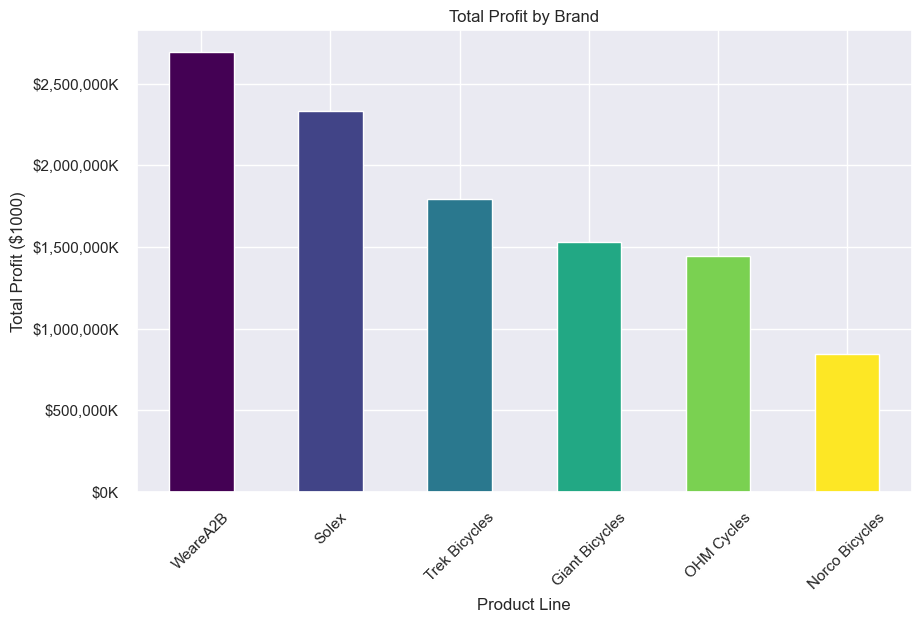

In [408]:
#Let's calculate the total profit
transactions['profit'] = transactions['list_price']- transactions['standard_cost']
profit_brand = transactions.groupby('brand')['profit'].sum().sort_values(ascending=False)

cmap2 = cm.get_cmap('viridis', len(profit_brand))
bx = profit_brand.plot(kind='bar', figsize=(10, 6), color=cmap2.colors)
plt.xlabel('Product Line')
plt.ylabel('Total Profit ($1000)')
plt.title('Total Profit by Brand')
plt.xticks(rotation=45)

# Format y-axis labels to show values in thousands
fmt = '${x:,.0f}K'
tick = mtick.StrMethodFormatter(fmt)
bx.yaxis.set_major_formatter(tick)

plt.show()

#### Observations
- WeareA2B and Solex generate the highest profit to the company
- Norco Bicycles generates the lowest 

Which brands sell the most?

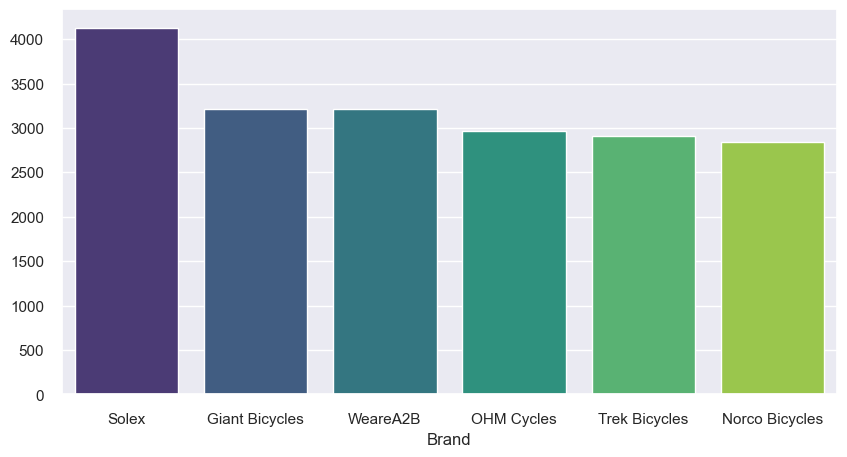

In [409]:
brand_order = transactions['brand'].value_counts().index

plt.figure(figsize=(10,5))
sns.countplot(data=transactions, x='brand', order=brand_order, palette='viridis')
plt.xlabel('Brand')
plt.ylabel('')
plt.show()

#### Observations
- Solex is the most popular Brand. 
- The rest of the brand follow a similar distribution

Which Product Line sell the most?

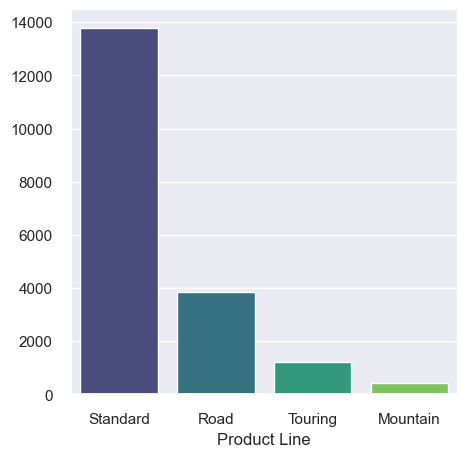

In [410]:
product_order = transactions['product_line'].value_counts().index

plt.figure(figsize=(5, 5))
sns.countplot(data=transactions, x='product_line', order=product_order, palette='viridis')
plt.xlabel('Product Line')
plt.ylabel('')
plt.show()

#### Observations
- Notably, Standard products sell the most. 
- The second most popular product are road product lines. 
- Compared to the above ones, Touring and Mountain products are barely sold

Are online orders more popular than in store orders?

In [411]:
online_order_counts = transactions['online_order'].value_counts()
online_order_counts

online_order
1.0    9642
0.0    9631
Name: count, dtype: int64

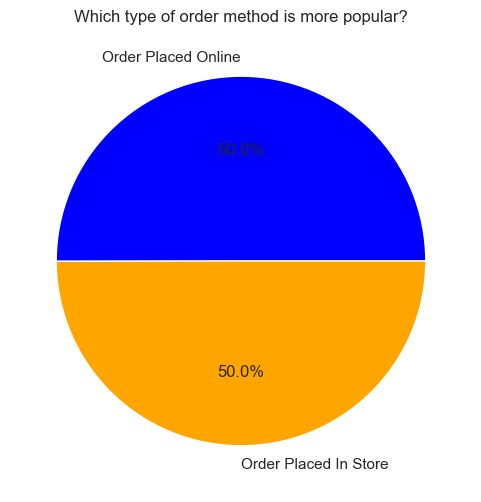

In [412]:
# Pie chart for the 'online_order' column
plt.figure(figsize=(6, 6))
plt.pie(online_order_counts, labels=['Order Placed Online', 'Order Placed In Store'], autopct='%1.1f%%', colors=['blue', 'orange'])
plt.title('Which type of order method is more popular?')
plt.show()

#### Observations
- Orders placed online and Orders placed in store are evenly distributed
- 50% / 50%

Which consumers should we target? Based on Gender

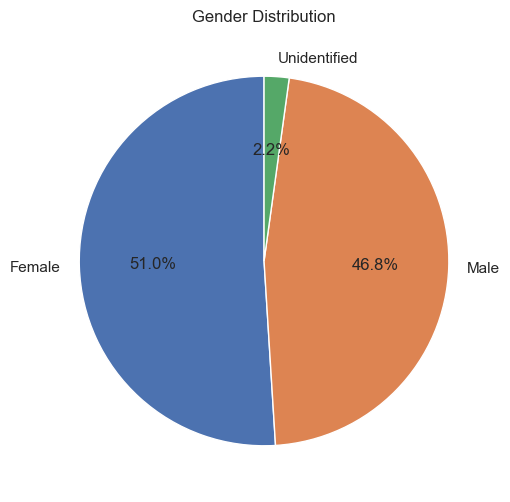

In [413]:
#GENDER
gender_type = old_cust['gender'].value_counts()

#Pie plot
plt.figure(figsize=(6, 6))
plt.pie(gender_type, labels=gender_type.index, autopct='%1.1f%%', startangle=90)

plt.title('Gender Distribution')
plt.show()

#### Observations
- Although there are more female clients than the male clients, genders are fairly distributed. 
- There is a 4% difference between both variables
- Unidentified only represents 2% of all the values


Let's compare age distribution between old customers and new customer

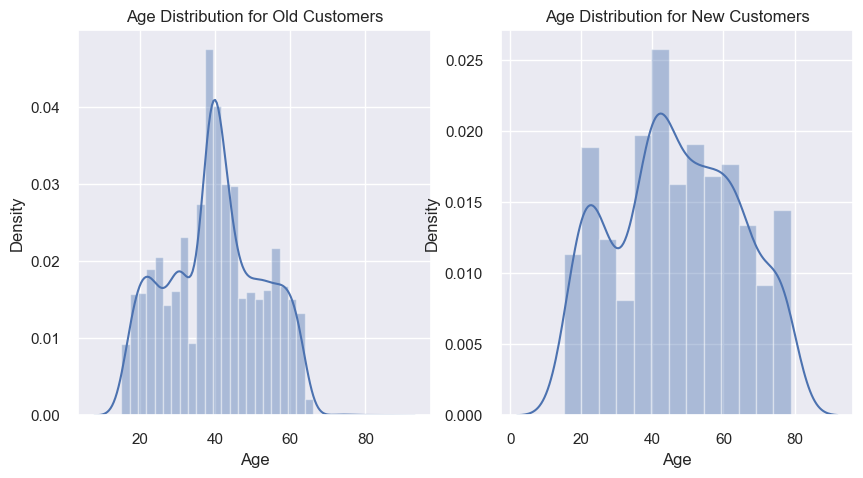

In [414]:
#AGE
fig, axs = plt.subplots(ncols=2, figsize=(10,5))

# Plot the first subplot
sns.distplot(old_cust['age'], ax=axs[0]);
axs[0].set_title('Age Distribution for Old Customers')
axs[0].set_xlabel('Age')
axs[0].set_ylabel('Density')

# Plot the second subplot
sns.distplot(new_cust['age'], ax=axs[1]);
axs[1].set_title('Age Distribution for New Customers')
axs[1].set_xlabel('Age')
axs[1].set_ylabel('Density')

plt.show()

In [415]:
with pd.option_context('display.width', None):
    display(pd.concat([new_cust['age'].describe(), old_cust['age'].describe()], axis=1))

,age,age
count,1000.000000,3995.000000
mean,46.713000,39.912390
std,17.361395,12.474163
min,15.000000,15.000000
25%,34.750000,31.000000
50%,46.000000,40.000000
75%,61.000000,49.000000
max,79.000000,86.000000


#### Observations
- Old customers average age is around 7 years older than the new customers average age

Correlation Matrix

Text(0.5, 1.0, 'Correlation Matrix')

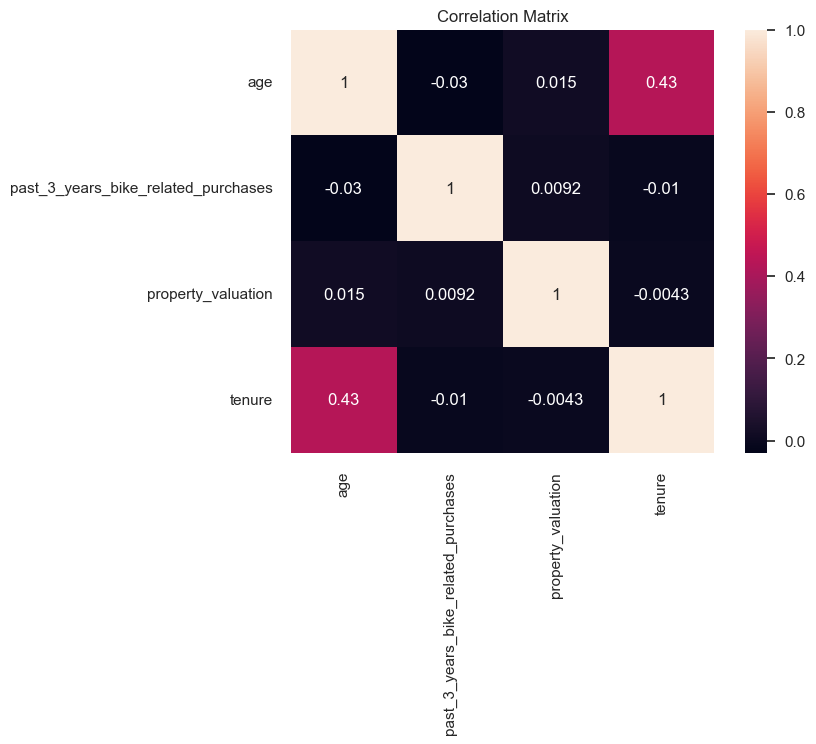

In [416]:
old_cust_values = old_cust[['age', 'past_3_years_bike_related_purchases', 'property_valuation', 'tenure']]
corr = old_cust_values.corr()
sns.heatmap(corr, square=True, annot = True)
plt.title('Correlation Matrix')

#### Observations
- There is a moderate correlation between ternure and age
- The rest of the variables are not correlated

## Cluster Analysis

For this project, We are going to compare RFM Plus Cluster, K-Means Clustering and K-Meloids Clustering. After this, we are choosing the best one that fits our data to be used to segragate the customers

### **RFM PLus Clustering**

- From the transactions column, we are calculating the frequency , recency and monetary and product margin cosumption. This last was added to answer questions like: how much profit do the products consumers buy generate?, do they tend to buy high or low profitable goods?
- To ensure data integrity, we are excluding rows with null values without altering the original dataset. Using as a base the 3484 unique_customer ids of the transactions table

In [58]:
# Lets create a new table
#use old_cust as a base
rfm = old_cust[['customer_id']].copy()

* Consumers Product Margin cosumption:

In [59]:
# RFM PLUS clustering: Recency, Frequency and Monetary value + margin product (set the profit per product)

# Product Margin: How much margin profit do the products consumers buy generate?, do they tend to buy high or low profitable goods?
transactions['margin_product'] = 100*(transactions['list_price'] - transactions['standard_cost'])/(transactions['list_price'])

profit_margin = transactions.groupby('customer_id')['margin_product'].mean()
rfm = rfm.merge(profit_margin, on='customer_id', how='left')

# To ensure data integrity, we are excluding rows with null values without altering the original dataset.
# Using as a base the 3484 unique_customer ids of the transactions table
rfm = rfm.dropna()

In [18]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3484 entries, 0 to 3494
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   customer_id     3484 non-null   object 
 1   margin_product  3484 non-null   float64
dtypes: float64(1), object(1)
memory usage: 81.7+ KB


In [20]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
margin_product,3484.0,44.586568,12.802619,7.221364,35.868943,43.977778,52.666616,98.960428


* Frequency

In [60]:
# RFM clustering: Recency, Frequency and Monetary value

#Frequency:  How often has a customer transacted  with the brand during a particular period of time?
frequency = transactions.groupby('customer_id').count()
frequency = frequency.loc[:, ['transaction_id']]
frequency =  frequency.rename(columns={'transaction_id': 'frequency'})
frequency.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3490 entries, 1 to 999
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   frequency  3490 non-null   int64
dtypes: int64(1)
memory usage: 54.5+ KB


In [61]:
# Merging and filling values 
rfm = rfm.merge(frequency, on='customer_id', how='left')
# Dropping null values
rfm = rfm.dropna()

In [62]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
margin_product,3484.0,44.586568,12.802619,7.221364,35.868943,43.977778,52.666616,98.960428
frequency,3484.0,5.521527,2.276557,1.000000,4.000000,5.000000,7.000000,14.000000


* Recency

In [63]:
#Recency:  How much time has passed since a customer’s last transaction with the brand?

day = "2017-12-31"
day = pd.to_datetime(day)
recency = transactions.groupby('customer_id').agg({"transaction_date":lambda x:((day-x.max()).days)})
recency = recency.loc[:, ['transaction_date']]
recency = recency.rename(columns={'transaction_date': 'recency'})
recency.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3490 entries, 1 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   recency  3490 non-null   int64
dtypes: int64(1)
memory usage: 54.5+ KB


In [64]:
# Merging and filling null values
rfm = rfm.merge(recency, on='customer_id', how='left')

# Dropping null values
rfm = rfm.dropna()

In [26]:
rfm.describe().T

,count,mean,std,min,25%,50%,75%,max
margin_product,3484.0,44.586568,12.802619,7.221364,35.868943,43.977778,52.666616,98.960428
frequency,3484.0,5.521527,2.276557,1.000000,4.000000,5.000000,7.000000,14.000000
recency,3484.0,63.830080,59.397181,1.000000,19.000000,46.000000,89.000000,354.000000


* Monetary 

In [65]:
#Monetary value: how much a customer has spent with the brand during a particular period of time
#therefore, let's sum how much each customer has spend according to the listed_price

monetary = transactions.groupby('customer_id')['list_price'].sum()
rfm = rfm.merge(monetary, on='customer_id', how='left')
rfm.rename(columns={'list_price':'monetary'}, inplace=True)

In [28]:
rfm.isnull().sum()

customer_id       0
margin_product    0
frequency         0
recency           0
monetary          0
dtype: int64

In [430]:
rfm.head()

,customer_id,margin_product,frequency,recency,monetary
0,1,32.258985,11,8,9084.45
1,2,55.472196,3,129,4149.07
2,4,22.374276,2,196,1047.72
3,5,34.201752,6,17,5903.20
4,6,55.116747,5,65,5931.69


**Let's calculate the score**
- Putting a score to each value in every column from 1 to 5
- This score represents the rank of each column being 1 the lowest score and 5 the highest score
- Note: in recency we invert it so it fits the score representation. Therefore, 5 represents low recency as that is the best value, while 1 represents high recency as that is the worst value.

In [66]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

rfm["margin_score"] = pd.qcut(rfm['margin_product'], 5, labels=[1, 2, 3, 4, 5])


rfm['score']=rfm['recency_score'].astype(int)+rfm['frequency_score'].astype(int)+rfm['monetary_score'].astype(int)+rfm["margin_score"].astype(int)

In [432]:
rfm.head()

,customer_id,margin_product,frequency,recency,monetary,recency_score,frequency_score,monetary_score,margin_score,score
0,1,32.258985,11,8,9084.45,5,5,5,1,16
1,2,55.472196,3,129,4149.07,1,1,2,5,9
2,4,22.374276,2,196,1047.72,1,1,1,1,4
3,5,34.201752,6,17,5903.20,4,3,3,2,12
4,6,55.116747,5,65,5931.69,2,2,3,5,12


### Best customers


In [67]:
rfm[rfm['score']== 20].sort_values('monetary', ascending=False).head()

,customer_id,margin_product,frequency,recency,monetary,recency_score,frequency_score,monetary_score,margin_score,score
315,322,67.179638,11,2,14770.22,5,5,5,5,20
1450,1460,71.638542,8,13,14633.24,5,5,5,5,20
1067,1076,57.147370,12,10,14390.10,5,5,5,5,20
722,729,59.875380,9,2,14032.57,5,5,5,5,20
2848,2860,55.966284,9,9,13804.79,5,5,5,5,20


- The customers having a score of '20' are considered as the 'best customers' as they have have the highest recency, frequency and monetary score.

- They are asset to the company.

**Number of best customers**

In [434]:
rfm[rfm['score']==20].count()

customer_id        30
margin_product     30
frequency          30
recency            30
monetary           30
recency_score      30
frequency_score    30
monetary_score     30
margin_score       30
score              30
dtype: int64

#### Observations:
- There are 30 Best customers in the company
- They are frequent buyers, generate high revenue, buy products that leave high profit margins and have recently buy with the company

### **Seggregate the levels**

We are going to seggregate the level of the customer based on the score. <br>
Here we have classified them into 4 levels. <br>

* Active : High revenue generating and frequent buyers .

* Good: Customers whose purchases are fairly frequent and generate moderate revenue.

* Average : Customers who are less active and are not very frequent buyers and generate low revenue.

* Inactive: Customers generating very low revenue and are occasional buyers.

In [68]:
def rfm_level(score):
    if  ((score >1) and (score < 6)):
        return 'Inactive'
    elif ((score > 5) and (score < 11)):
        return 'Average'
    elif ((score > 10) and (score < 16)):
        return 'Good'
    else:
        return 'Active'

In [69]:
rfm['level'] = rfm['score'].apply(lambda score : rfm_level(score))
rfm.head()

,customer_id,margin_product,frequency,recency,monetary,recency_score,frequency_score,monetary_score,margin_score,score,level
0,1,32.258985,11,8,9084.45,5,5,5,1,16,Active
1,2,55.472196,3,129,4149.07,1,1,2,5,9,Average
2,4,22.374276,2,196,1047.72,1,1,1,1,4,Inactive
3,5,34.201752,6,17,5903.20,4,3,3,2,12,Good
4,6,55.116747,5,65,5931.69,2,2,3,5,12,Good


Visualising the number of customers for each level

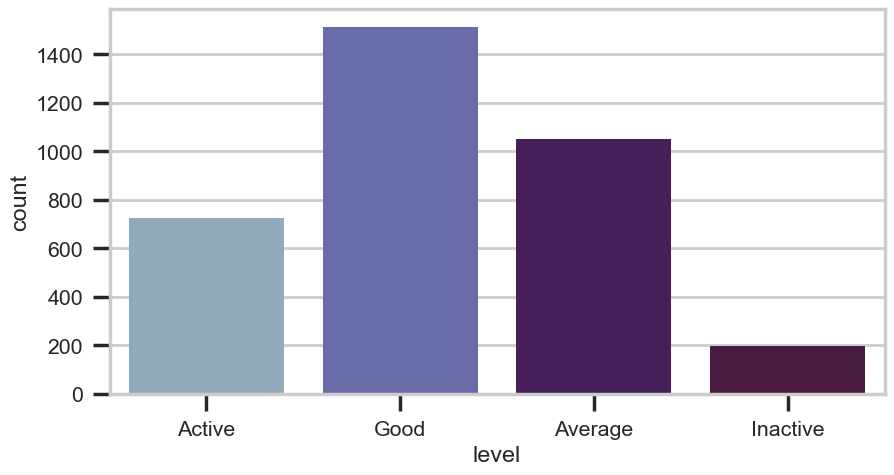

In [34]:
category_order = ['Active', 'Good', 'Average', 'Inactive']

plt.figure(figsize=(10, 5))
sns.set_context("poster", font_scale=0.7)
sns.set_palette('twilight')
sns.countplot(x=rfm['level'], order=category_order)
plt.show()

#### Observations

* There are less than 200 inactive customers, a low amount compared to the other customer types.
* There are over 1400 Good Customers, being the biggest segment. It is more than double of the amount of Active customers.
* It is followed by around 1000 Average customers

Clustering Profile

In [35]:
#To understand each segment of customers better, we are going to deep dive on each segment.
rfm.groupby('level').agg({
    'recency' : ['mean', 'min','max'],
    'frequency' : ['mean', 'min','max'],
    'monetary' : ['mean','min','max'],
    'margin_product' : ['mean','min','max','count']
}).style.highlight_max(color = "lightblue", axis = 0)

**Active Customers**

* 726 customers has on average spent a total of 9744 dollars each by shopping 8 times approximately every 24 days, purchasing in average products that generated 0.50 percent of profit so high margin products

* They are previliged customers.

* Surprise offers can be given on birthdays and anniversary.

**Good Customers**

* 1510 customers has on average spent a total of 1036 dollars each by shopping 6 times every 51 days, purchasing in average products that generated 0.46 percent of profit so high margin products

* They are loyal customers.

**Average customers**

* 1501 customers has on average spent a total of 3887 dollars each by shopping 4 times every 92 days, purchasing in average products that generated 0.41 percent of profit so average margin products

* Tiered pricing of products can be introduced.

**Inactive customers**

* 197 customers has on average spent a total of 2039 dollars each by shopping twice every 162 days, purchasing in average products that generated 0.27 percent of profit so low margin products

* Personalised emails and SMS can be sent to the customers regarding the offers.

* More marketing strategies can be introduced to improve the frequency of orders.

In [439]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3484 entries, 0 to 3483
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   customer_id      3484 non-null   object  
 1   margin_product   3484 non-null   float64 
 2   frequency        3484 non-null   int64   
 3   recency          3484 non-null   int64   
 4   monetary         3484 non-null   float64 
 5   recency_score    3484 non-null   category
 6   frequency_score  3484 non-null   category
 7   monetary_score   3484 non-null   category
 8   margin_score     3484 non-null   category
 9   score            3484 non-null   int32   
 10  level            3484 non-null   object  
dtypes: category(4), float64(2), int32(1), int64(2), object(2)
memory usage: 191.5+ KB


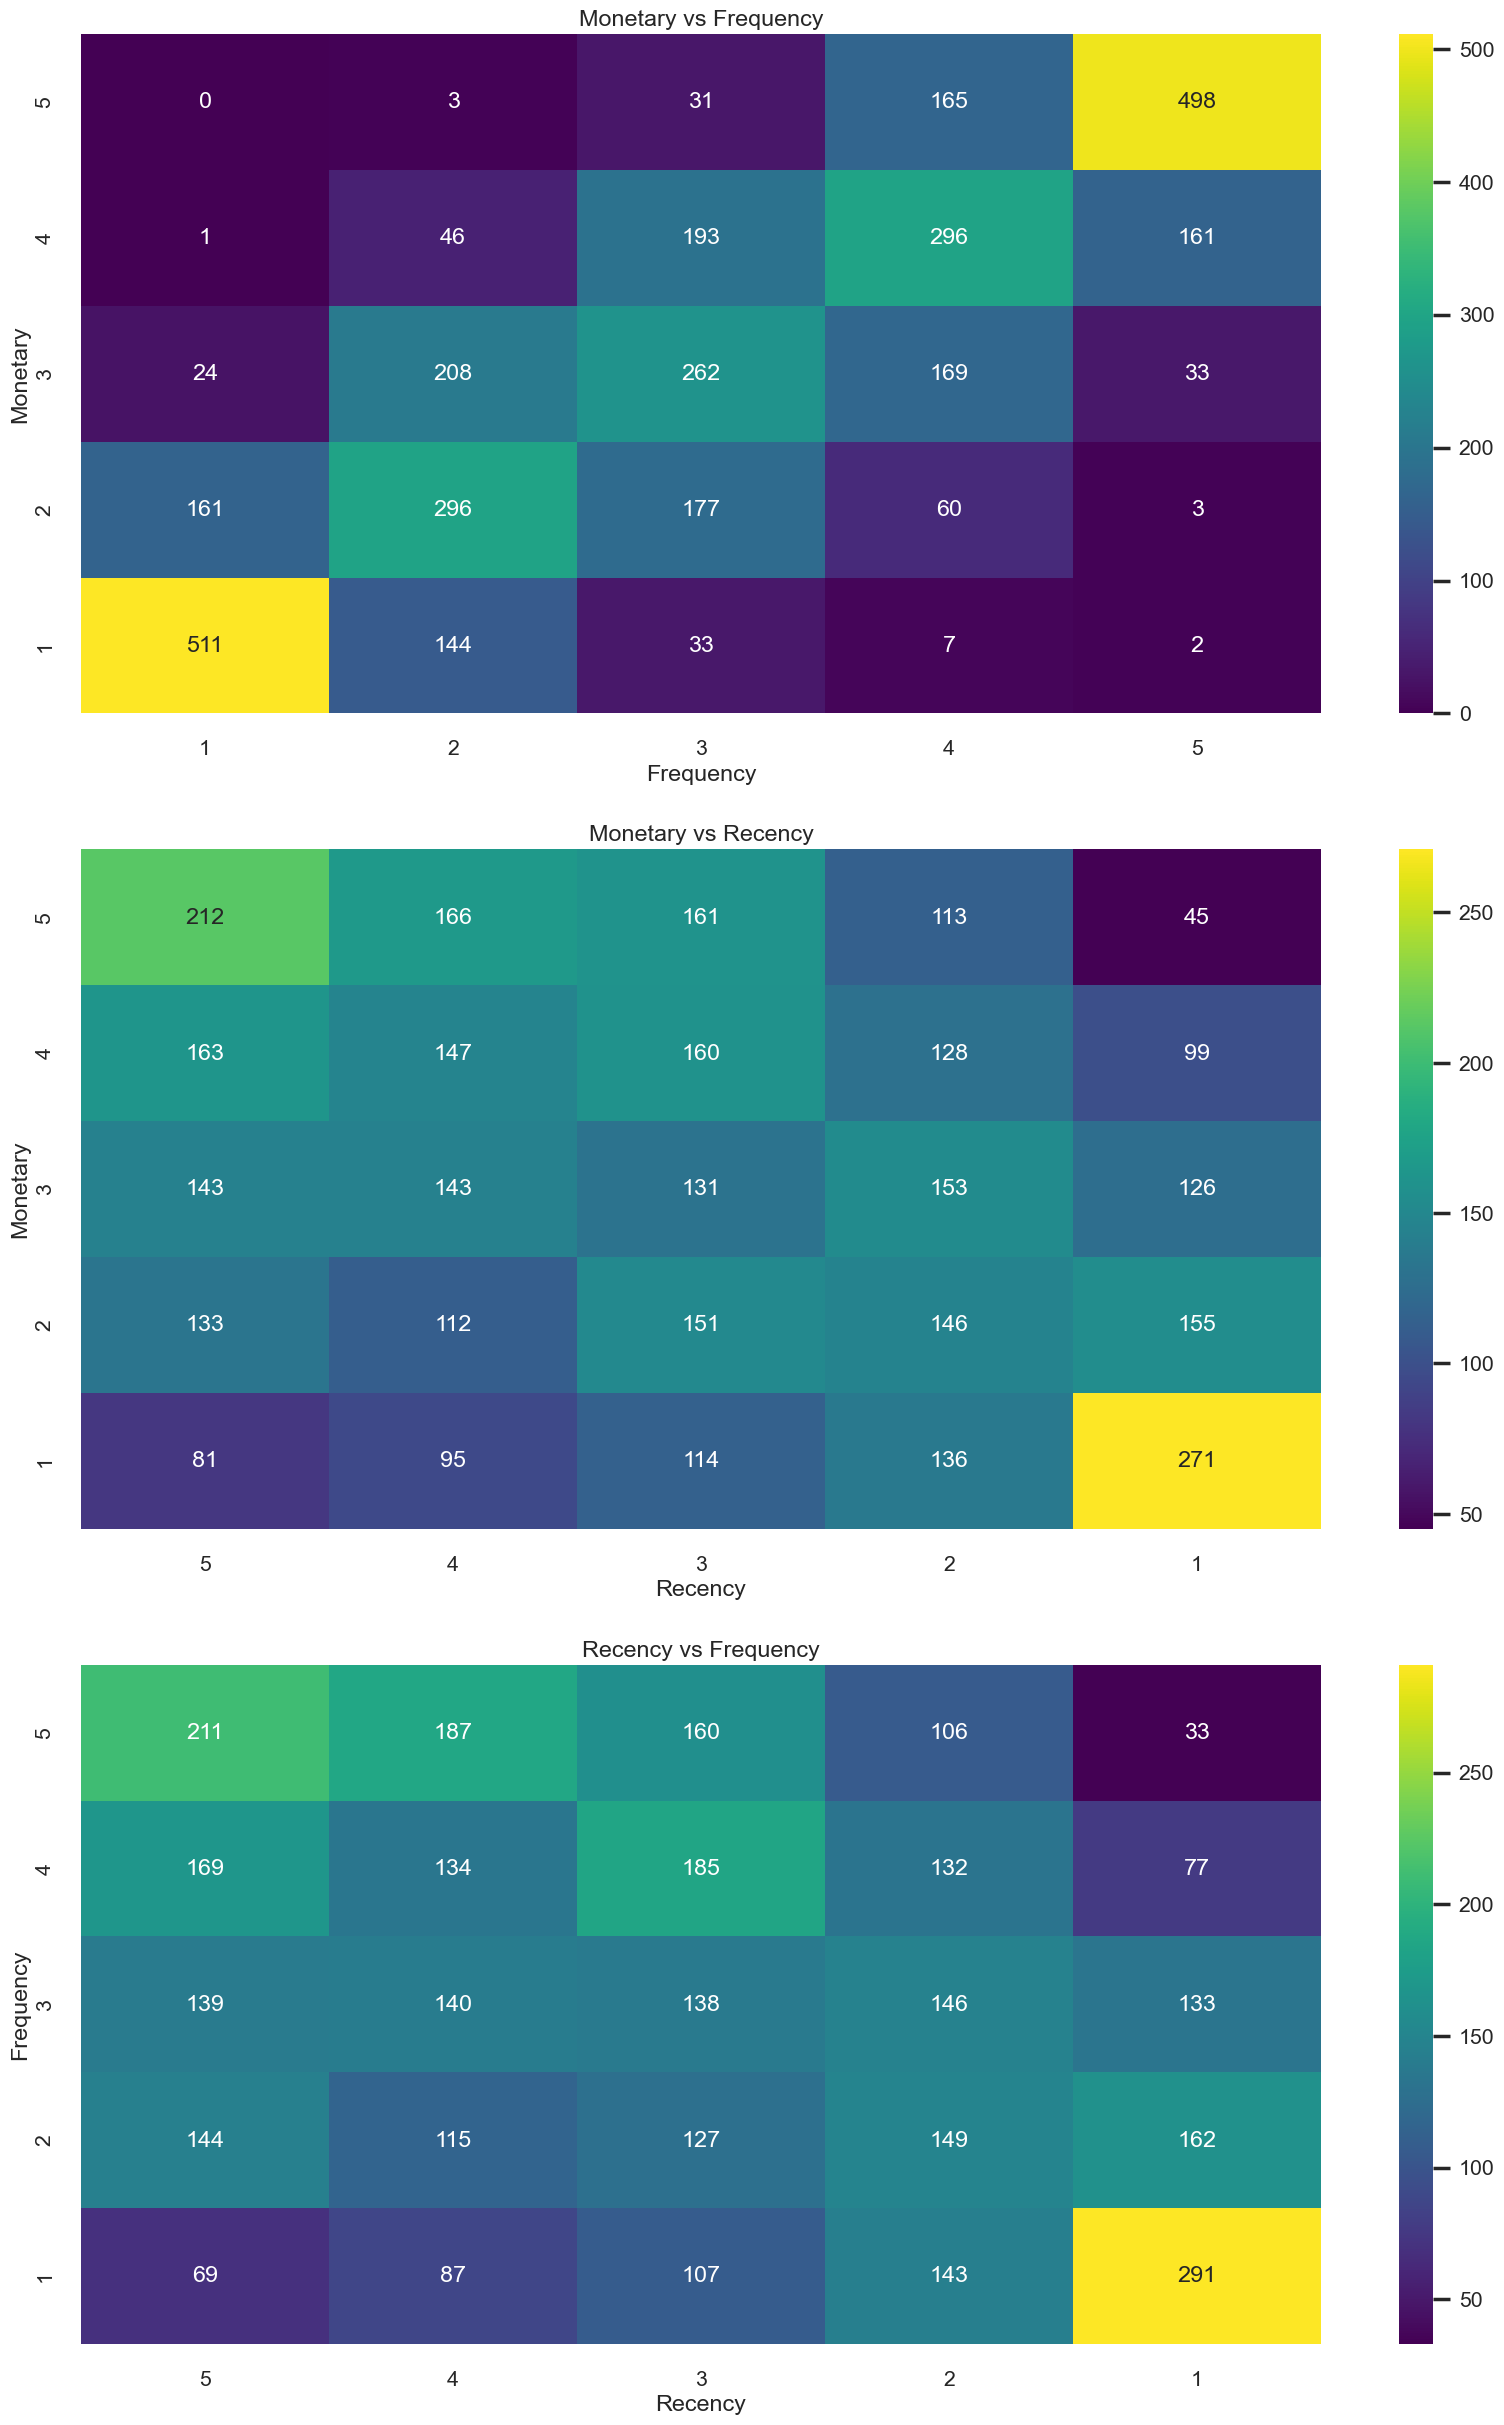

In [440]:
cross_table1 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['frequency_score'])
cross_table2 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['recency_score'])
cross_table3 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['recency_score'])
cross_table4 = pd.crosstab(index=rfm['monetary_score'], columns=rfm['margin_score'])
cross_table5 = pd.crosstab(index=rfm['frequency_score'], columns=rfm['margin_score'])
cross_table6 = pd.crosstab(index=rfm['recency_score'], columns=rfm['margin_score'])

plt.figure(figsize=(20,30))
plt.subplot(311)
ax1 = sns.heatmap(cross_table1, cmap='viridis', annot=True, fmt=".0f")
ax1.invert_yaxis()
ax1.set_ylabel('Monetary')
ax1.set_xlabel('Frequency')
ax1.set_title('Monetary vs Frequency')
plt.subplot(312)
ax2 = sns.heatmap(cross_table2, cmap='viridis', annot=True, fmt=".0f")
ax2.invert_yaxis()
ax2.set_ylabel('Monetary')
ax2.set_xlabel('Recency')
ax2.set_title('Monetary vs Recency')
plt.subplot(313)
ax3 = sns.heatmap(cross_table3, cmap='viridis', annot=True, fmt=".0f")
ax3.invert_yaxis()
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Recency')
ax3.set_title('Recency vs Frequency')
plt.show()

#### Segmenting customer based on their levels

In [441]:
active = rfm[rfm['level'] == 'Active']
average = rfm[rfm['level'] == 'Average']
good = rfm[rfm['level'] == 'Good']
inactive = rfm[rfm['level'] == 'Inactive']

#### Conclusions: RFM Plus

- Effective Segmentation: The RFM Plus analysis has resulted in well-defined customer segments, aligning with our expectations and objectives.

- Balanced Distribution: The majority of customer segments exhibit a fair distribution of clients, indicating that the segmentation process effectively categorized customers based on their recency, frequency, monetary and product margin values.

- Exception: Inactive Segment: It's noteworthy that the inactive customer segment deviates from the balanced distribution

## K-Means Clustering

We are going to apply unsupervised machine learning to identify different groups/clusters based on segmentation of customers according to their purchasing behaviour.

The overall clusters will be based on the 4 factors - recency, frequency and monetary values, product margin

In [442]:
rfm.describe()

,margin_product,frequency,recency,monetary,score
count,3484.000000,3484.000000,3484.000000,3484.000000,3484.000000
mean,44.586568,5.521527,63.830080,6111.884974,12.016935
std,12.802619,2.276557,59.397181,2896.861188,3.837048
min,7.221364,1.000000,1.000000,60.340000,4.000000
25%,35.868943,4.000000,19.000000,4020.770000,9.000000
50%,43.977778,5.000000,46.000000,5827.935000,12.000000
75%,52.666616,7.000000,89.000000,7931.665000,15.000000
max,98.960428,14.000000,354.000000,19071.320000,20.000000


Since k-means clustering is sensitive to outliers, we are treating the them

In [443]:
rfm2 = rfm.copy() # copy of the data with outliers

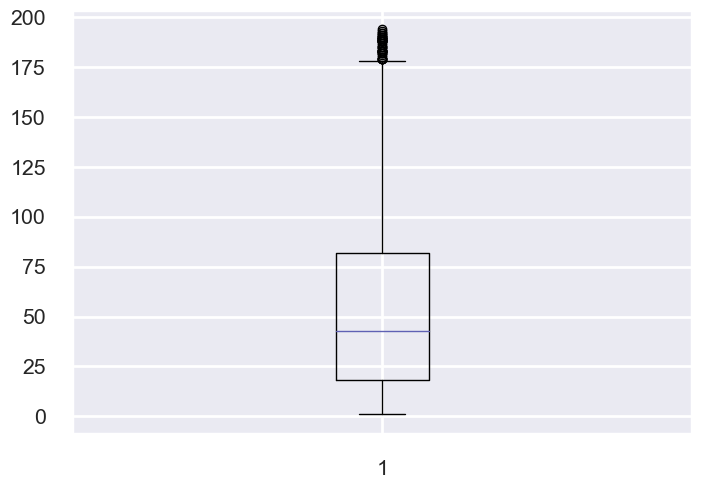

In [445]:
#Outlier treatment for recency
plt.boxplot(rfm.recency)
Q1 = rfm.recency.quantile(0.25)
Q3 = rfm.recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.recency >= Q1 - 1.5*IQR) & (rfm.recency <= Q3 + 1.5*IQR)]

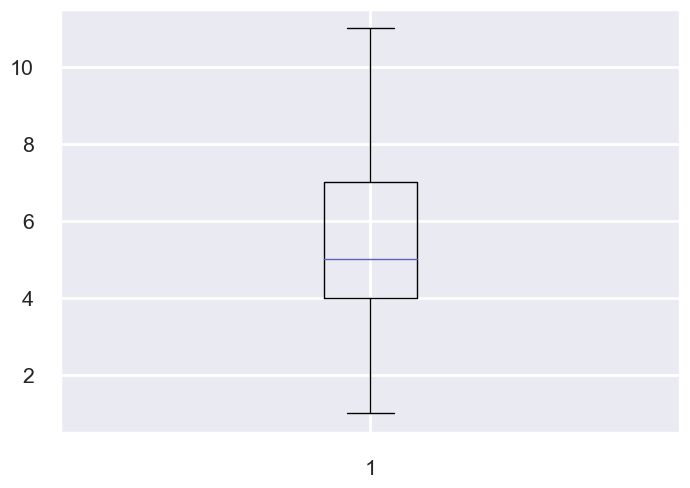

In [448]:
#Outlier treatment for frequency
plt.boxplot(rfm.frequency)
Q1 = rfm.frequency.quantile(0.25)
Q3 = rfm.frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.frequency >= Q1 - 1.5*IQR) & (rfm.frequency <= Q3 + 1.5*IQR)]

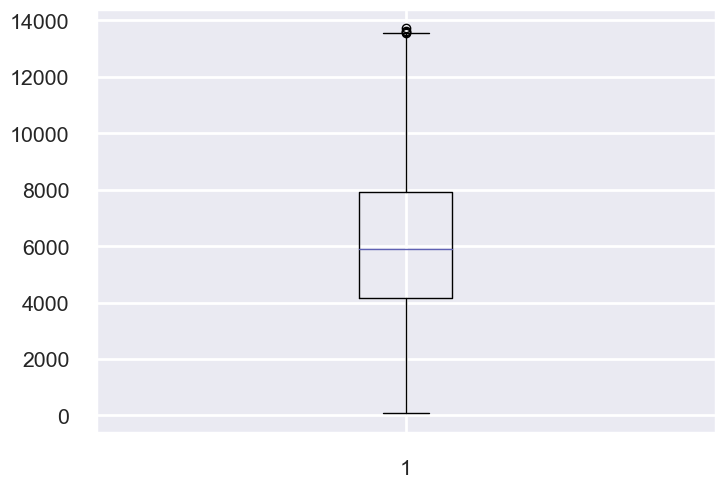

In [450]:
#Outlier treatment for frequency
plt.boxplot(rfm.monetary)
Q1 = rfm.monetary.quantile(0.25)
Q3 = rfm.monetary.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.monetary >= (Q1 - 1.5*IQR)) & (rfm.monetary <= (Q3 + 1.5*IQR))]

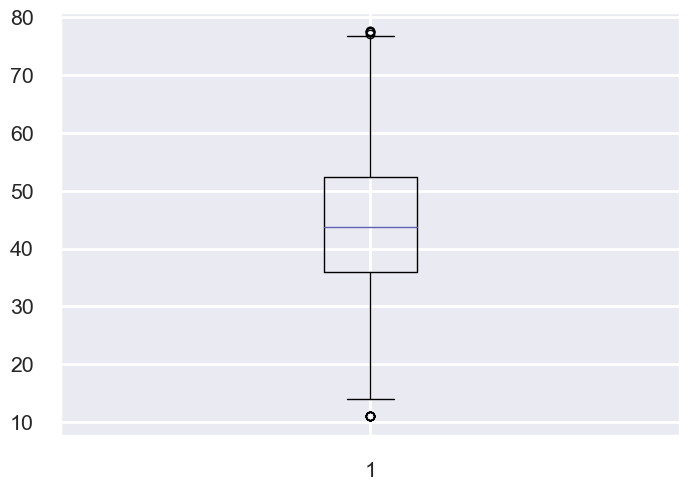

In [452]:
#Outlier treatment for margin_product
plt.boxplot(rfm.margin_product)
Q1 = rfm.margin_product.quantile(0.25)
Q3 = rfm.margin_product.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.margin_product >= (Q1 - 1.5*IQR)) & (rfm.margin_product <= (Q3 + 1.5*IQR))]

**Transfroming the data**

In [454]:
rfm1=rfm[['recency','frequency','monetary','margin_product']]
scaler = StandardScaler()
x_scaled=scaler.fit(rfm1)
x_scaled = scaler.fit_transform(rfm1)
x_scaled

array([[-1.05428773,  2.59566085,  1.09874274, -1.02557029],
       [ 1.70580248, -1.25196053, -0.75523608,  0.94948806],
       [-0.84899176,  0.19089749, -0.09629596, -0.86027311],
       ...,
       [ 1.68299182,  0.19089749, -0.36907094,  0.22402818],
       [-0.05061856,  0.67185016,  0.56871091,  1.01536686],
       [ 2.07077309,  0.19089749, -0.46473039, -1.02857084]])

**Elbow method**

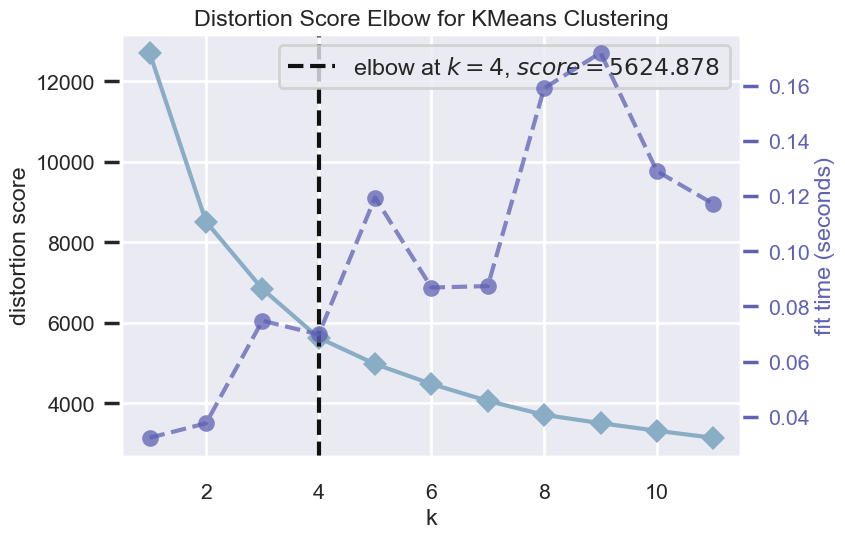

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [455]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(x_scaled)  
visualizer.show()   

- According to the Elbow method, the number of clusters is 4.

### Applying K-means

[1 2 2 ... 2 1 2]
 Our cluster centers are as follows
[[ 1.65120379 -0.64281117 -0.57940502 -0.26306402]
 [-0.22727723 -0.46322429 -0.26329994  1.08619501]
 [-0.40018805  1.11787595  1.08637635  0.05309336]
 [-0.40319264 -0.50851804 -0.68289842 -0.81864297]]


,recency,frequency,monetary,margin_product
cluster_pred,,,,
0,559,559,559,559
1,737,737,737,737
2,1019,1019,1019,1019
3,862,862,862,862


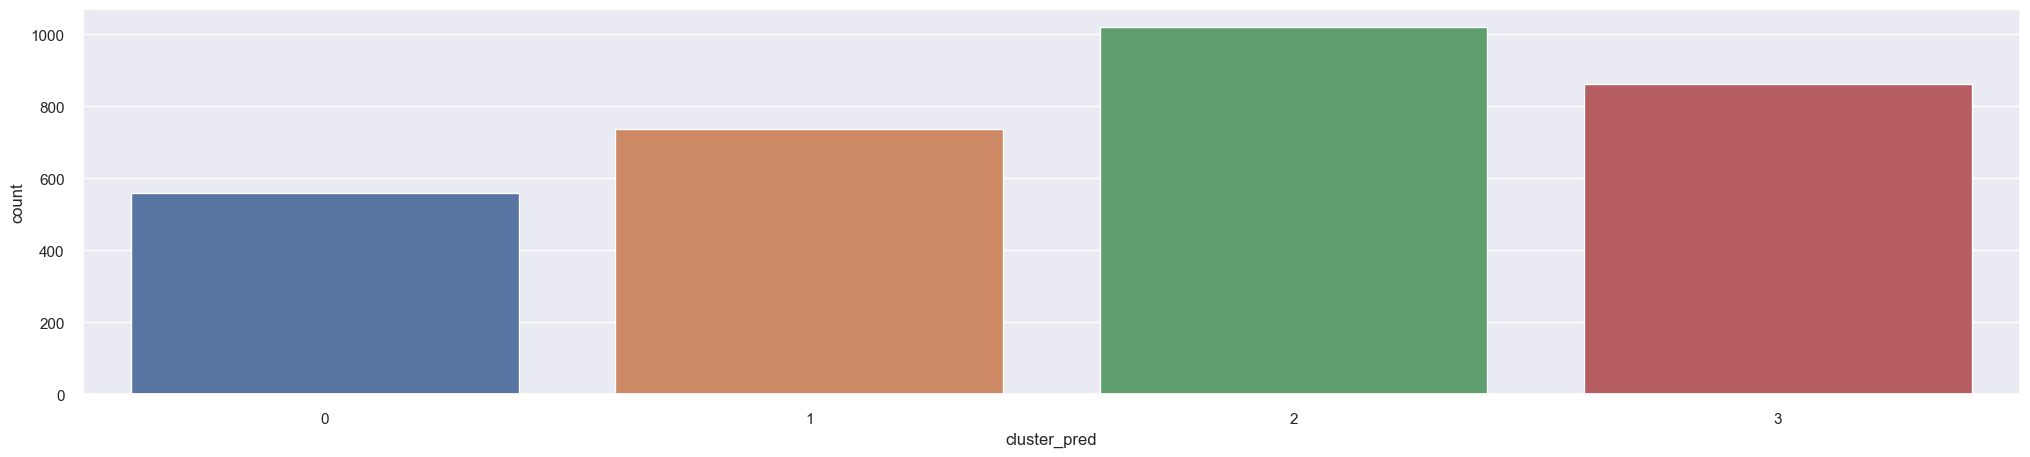

In [456]:
kmeans_scaled = KMeans(4)
kmeans_scaled.fit(x_scaled)
identified_clusters = kmeans_scaled.fit_predict(rfm1)
clusters_scaled = rfm1.copy()
clusters_scaled['cluster_pred']=kmeans_scaled.fit_predict(x_scaled)
print(identified_clusters)
sns.set(style="darkgrid")
print(" Our cluster centers are as follows")
print(kmeans_scaled.cluster_centers_)
f, ax = plt.subplots(figsize=(25, 5))
ax = sns.countplot(x="cluster_pred", data=clusters_scaled)
clusters_scaled.groupby(['cluster_pred']).count()

**Visualizing the clusters**

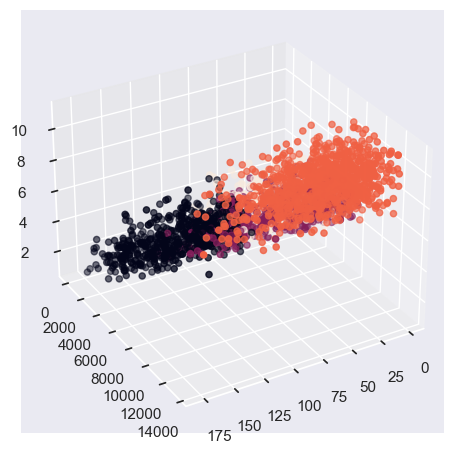

In [457]:
fig = plt.figure()
ax = plt.axes(projection='3d')
xline=clusters_scaled['recency']
yline=clusters_scaled['frequency']
zline=clusters_scaled['monetary']

ax.scatter3D(xline, zline,yline,c=clusters_scaled['cluster_pred'])
ax.view_init(30, 60)

**Validation**

We will use Silhoutte score to validate our clusters.

Silhouette Score: 0.267


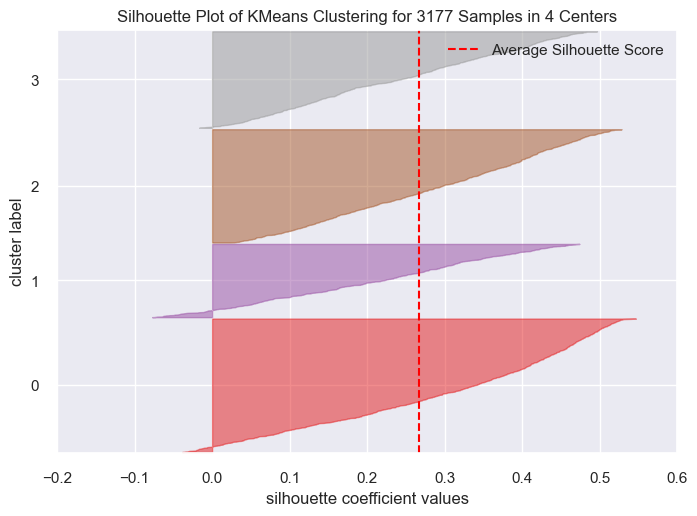

<Axes: title={'center': 'Silhouette Plot of KMeans Clustering for 3177 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [458]:
from sklearn.metrics import silhouette_samples, silhouette_score
sil_score = silhouette_score(x_scaled, kmeans_scaled.labels_, metric='euclidean')
print('Silhouette Score: %.3f' % sil_score)

from yellowbrick.cluster import SilhouetteVisualizer
model = KMeans(4)
visualizer = SilhouetteVisualizer(model)
visualizer.fit(x_scaled)   
visualizer.poof()   
   

#### Cluster Profile
We are going to analyse and understand each clusters.

In [459]:
rfm1['cluster']= clusters_scaled['cluster_pred']
rfm1['level']=rfm['level']

rfm1.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max'],
    'margin_product' : ['mean','min','max','count']
}).style.highlight_max(color = "lightblue", axis = 0)

**Cluster 0**

* 559 customers has on average spent a total of 4617 dollars each by shopping 4 times approximately every 127 days, purchasing in average products that generated 0.41 percent of profit so high margin products

**Cluster 1**

* 737 customers has on average spent a total of 5458 dollars each by shopping 5 times every 44 days, purchasing in average products that generated 0.57 percent of profit so high margin products

**Cluster 2**

* 1019 customers has on average spent a total of 9051 dollars each by shopping 8 times every 37 days, purchasing in average products that generated 0.45 percent of profit so average margin products

* The most valuable group of customers with highest mean frequency (purchase most often), the highest mean monetary (high purchasing amount), the second highest margin product and second the lowest rencency (how long has it pass since the last purchase? So the lowest the better)

**Cluster 3**

* 862 customers has on average spent a total of 4340 dollars each by shopping 4 time every 37 days, purchasing in average products that generated 0.35 percent of profit so low margin products


#### Nature of the cluster
- We need to check whether the predicted clusters are homogeneous or heterogeneous in nature.

In [460]:
rfm1.groupby(['cluster','level']).size()

cluster  level   
0        Average     334
         Good        132
         Inactive     93
1        Active      102
         Average     104
         Good        531
2        Active      567
         Good        452
3        Average     480
         Good        352
         Inactive     30
dtype: int64

* Cluster 0 is heterogenous in nature. It has Good, Average and Inactive customers.

* Cluster 1 is heterogenous in nature. It has Good customers in majority, and Active and Average customers in minority

* Cluster 2 is heterogenous in nature. It comprises Active and Good customers.

* Cluster 3 is heterogenous in nature. It has Good and Average customers in majority, and Inactive customers in minority

#### Conclusions: K-Means Clustering

- Unclear Segment Boundaries: The segmentation results indicate that the clusters are not distinctly separated. While there is a clear most valuable customer segment (cluster 2), the proximity of its characteristics to other segments blurs the boundaries between them.

- Ambiguity in Defining Segments: The challenge lies in precisely defining each customer segment due to the overlapping characteristics. This ambiguity makes it challenging to categorize customers into well-defined groups.

- Balanced Distribution: The number of customers is relatively well-distributed among the clusters. 

## K-Meloids

Since K-meloids is robust to outliers, we are using the copy RFM with outliers to not lose any data

In [462]:
#Scaling the data
rfm3=rfm2[['recency','frequency','monetary','margin_product']]
scaler = StandardScaler()
x_scaled=scaler.fit(rfm3)
x_scaled = scaler.fit_transform(rfm3)
x_scaled

array([[-0.94007988,  2.40681844,  1.02628035, -0.9630336 ],
       [ 1.09734626, -1.10776445, -0.67766337,  0.85038774],
       [ 2.22550784, -1.54708731, -1.74840684, -1.73522931],
       ...,
       [ 1.08050803,  0.21020414, -0.32274904,  0.18429885],
       [-0.19919764,  0.649527  ,  0.53914188,  0.91087508],
       [ 1.36675798,  0.21020414, -0.41066715, -0.96578858]])

In [463]:
kmed = KMedoids(n_clusters = 4, random_state = 1) 
kmed.fit(rfm3)

KMedoids(n_clusters=4, random_state=1)

In [464]:
df2 = rfm3.copy()

rfm3["KMed_segments"] =  kmed.labels_ # Adding K-Medoids cluster labels to K-Medoids data

df2["KMed_segments"] =  kmed.labels_ # Adding K-Medoids cluster labels to the whole data

#### Cluster Profile
We are going to analyse and understand each clusters.

In [465]:
rfm3['cluster']= clusters_scaled['cluster_pred']
rfm3['level']=rfm['level']

rfm3.groupby('cluster').agg({
    'recency' : ['mean','min','max'],
    'frequency' : ['mean','min','max'],
    'monetary' : ['mean','min','max'],
    'margin_product' : ['mean','min','max','count']
}).style.highlight_max(color = "lightblue", axis = 0)

**Cluster 0**

* 559 customers has on average spent a total of 4617 dollars each by shopping 4 times approximately every 127 days, purchasing in average products that generated 0.41 percent of profit so high margin products

* The least valuable customer

**Cluster 1**

* 737 customers has on average spent a total of 5458 dollars each by shopping 5 times every 44 days, purchasing in average products that generated 0.57 percent of profit so high margin products


**Cluster 2**


* 1019 customers has on average spent a total of 9051 dollars each by shopping 8 times every 37 days, purchasing in average products that generated 0.45 percent of profit so average margin products

* The most valuable customer

**Cluster 3**

* 862 customers has on average spent a total of 4340 dollars each by shopping 5 time every 37 days, purchasing in average products that generated 0.35 percent of profit so low margin products

#### Nature of the cluster
- We need to check whether the predicted clusters are homogeneous or heterogeneous in nature.

In [467]:
rfm3.groupby(['cluster','level']).size()

cluster  level   
0.0      Average     334
         Good        132
         Inactive     93
1.0      Active      102
         Average     104
         Good        531
2.0      Active      567
         Good        452
3.0      Average     480
         Good        352
         Inactive     30
dtype: int64

* Cluster 0 is heterogenous in nature. It comprises Average, Good and Inactive customers.

* Cluster 1 is heterogenous in nature. It comprises Good in majority, and Average and Active in minority.

* Cluster 2 is heterogenous in nature. It comprises Active and Good customers.

* Cluster 3 is is heterogenous in nature. It comprises Average, Good in majority, and Inactive in minority.

#### Conclusions: K-meloids

- Heterogeneous Clusters: All identified clusters exhibit heterogeneity within themselves

- Improved Segment Distinction: While there is a more discernible understanding of segment distinctions compared to traditional k-means clustering, the proximity of these values to other segments still poses challenges in precisely defining each cluster.

- Moderately Balanced Distribution: The number of customers is relatively well-distributed among the clusters. 

### Comparing RFM Plus analysis, K-Means and K-Meloids clustering

##### **Snake plot**
- Transforming and storing the values for plotting a snake plot.

In [468]:
#RFM Plus
rfm_scaled=pd.DataFrame()
rfm_scaled=rfm1.copy()
scaler=StandardScaler()
rfm_scaled[['recency', 'frequency','monetary', 'margin_product']] = scaler.fit_transform(rfm_scaled[['recency', 'frequency','monetary','margin_product']])
rfm_scaled['cust_id']=rfm1.index

In [469]:
#K-Meloid
rfm3 = rfm3.drop('cluster', axis=1)

rfm3_scaled=pd.DataFrame()
rfm3_scaled=rfm3.copy()
scaler=StandardScaler()
rfm3_scaled[['recency', 'frequency','monetary', 'margin_product']] = scaler.fit_transform(rfm3_scaled[['recency', 'frequency','monetary','margin_product']])

In [470]:
rfm_scaled.head()


,recency,frequency,monetary,margin_product,cluster,level,cust_id
0,-1.054288,2.595661,1.098743,-1.025570,2,Active,0
1,1.705802,-1.251961,-0.755236,0.949488,0,Average,1
3,-0.848992,0.190897,-0.096296,-0.860273,3,Good,3
4,0.245920,-0.290055,-0.085594,0.919245,1,Good,4
6,-0.712128,1.633756,1.417610,0.500650,2,Active,6


In [471]:
rfm3.head()

,recency,frequency,monetary,margin_product,KMed_segments,level
0,8,11,9084.45,32.258985,0,Active
1,129,3,4149.07,55.472196,3,Average
2,196,2,1047.72,22.374276,2,NaN
3,17,6,5903.20,34.201752,3,Good
4,65,5,5931.69,55.116747,3,Good


Melting the dataframe

In [473]:
rfm_melted = pd.melt(frame= rfm_scaled, id_vars= ['cust_id', 'level', 'cluster'], var_name = 'metrics', value_name = 'value')
rfm_melted.head()

,cust_id,level,cluster,metrics,value
0,0,Active,2,recency,-1.054288
1,1,Average,0,recency,1.705802
2,3,Good,3,recency,-0.848992
3,4,Good,1,recency,0.245920
4,6,Active,2,recency,-0.712128


In [474]:
rfm3_melted = pd.melt(frame= rfm3_scaled, id_vars= ['level', 'KMed_segments' ], var_name = 'metrics', value_name = 'value')
rfm3_melted.head()

,level,KMed_segments,metrics,value
0,Active,0,recency,-0.940080
1,Average,3,recency,1.097346
2,NaN,2,recency,2.225508
3,Good,3,recency,-0.788536
4,Good,3,recency,0.019699


- Snake plot based on RFM segmentation

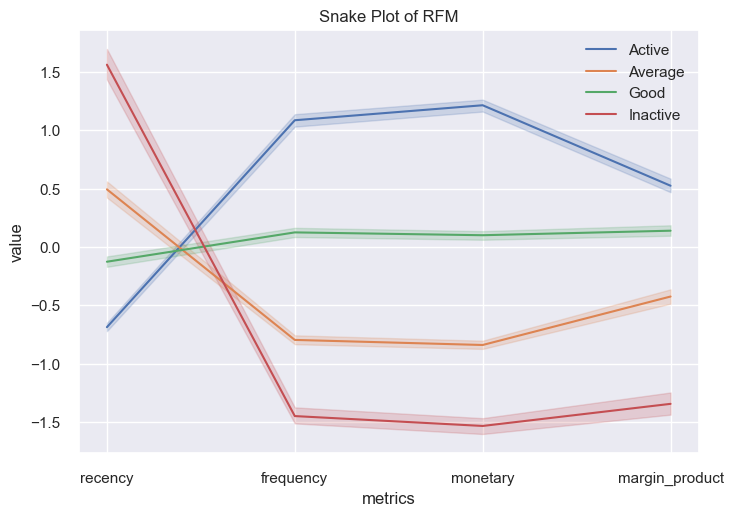

In [475]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'level', data = rfm_melted)
plt.title('Snake Plot of RFM')
plt.legend(loc = 'upper right')

- Snake plot with clusters using K-Means

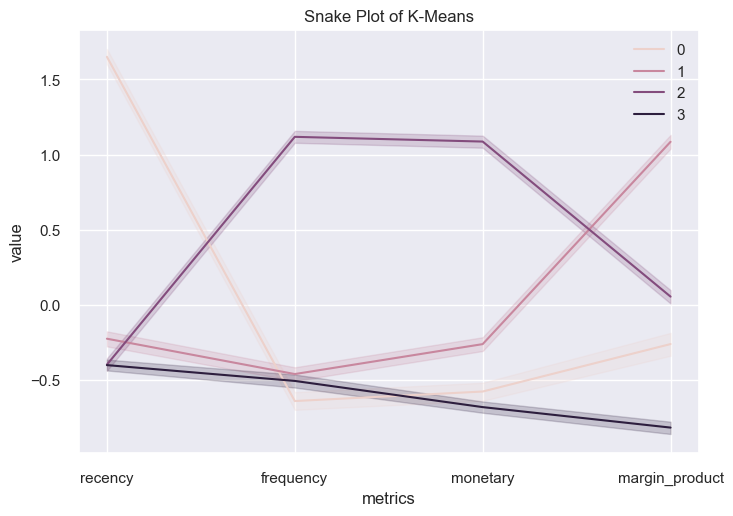

In [476]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'cluster', data = rfm_melted)
plt.title('Snake Plot of K-Means')
plt.legend(loc = 'upper right')

- Snake plot with clusters using K-Meloids

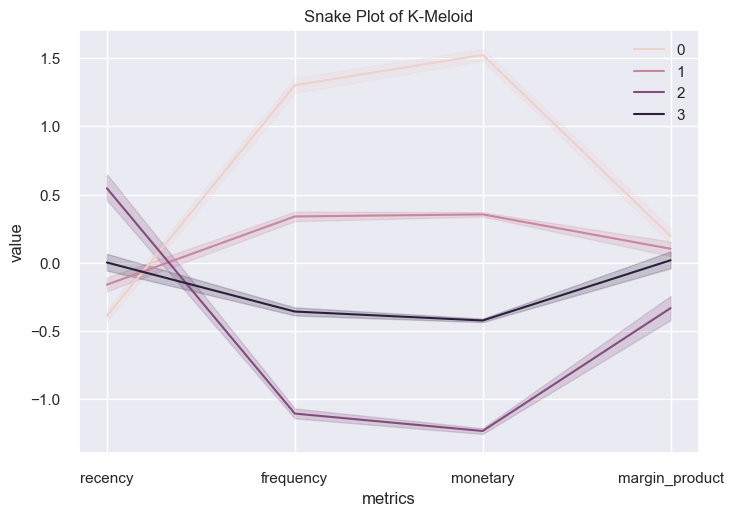

In [477]:
sns.lineplot(x = 'metrics', y = 'value', hue = 'KMed_segments', data = rfm3_melted)
plt.title('Snake Plot of K-Meloid')
plt.legend(loc = 'upper right')

### Conclusions

We made three kinds of segmentation, RFM Plus quantiles, K-Means clustering and K-meloid clustering. <br>

- After careful examination, we have determine that **RFM Plus** gives a greater segmentation of the clusters. Therefore, it will be the one use for the customer analysis 
- Customers have been categorized into 4 segments based on Recency, Frequency and Monetary value of their purchases. Knowing these categories, Sprocket Central can create targeted strategy to be applied to each customer segment. <br>

With the result, <br>

* We figured out ‘best’ customers, the most profitable group.
* This also tells us on which customer group we should focus on and to whom to give special offers or promotions among the customers.
* We can select the best communication channel for each segment and improve new marketing strategies.

# Customer analysis

After identifying the cluster we are going to analyse the characterics of each RFM Plus group through Exploratory Data Analysis and determine the customer profile of each segment

#### Data Preparation

In [479]:
rfm.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3177 entries, 0 to 3483
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   customer_id      3177 non-null   object  
 1   margin_product   3177 non-null   float64 
 2   frequency        3177 non-null   int64   
 3   recency          3177 non-null   int64   
 4   monetary         3177 non-null   float64 
 5   recency_score    3177 non-null   category
 6   frequency_score  3177 non-null   category
 7   monetary_score   3177 non-null   category
 8   margin_score     3177 non-null   category
 9   score            3177 non-null   int32   
 10  level            3177 non-null   object  
dtypes: category(4), float64(2), int32(1), int64(2), object(2)
memory usage: 328.4+ KB


In [70]:
# Merging RFM and old_cust table on customer id: 
rfm['customer_id'] = rfm['customer_id'].astype(str)

old_cust = old_cust.merge(rfm[['customer_id', 'level']], on='customer_id', how='left')

old_cust.shape

(3995, 18)

In [71]:
#dropping duplicate
old_cust.duplicated().sum()
old_cust.drop_duplicates(inplace=True)
old_cust.shape

(3995, 18)

In [72]:
#dropping rows with missing values
old_cust = old_cust.dropna()

In [73]:
old_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3484 entries, 0 to 3494
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3484 non-null   object 
 1   first_name                           3484 non-null   object 
 2   last_name                            3484 non-null   object 
 3   gender                               3484 non-null   object 
 4   past_3_years_bike_related_purchases  3484 non-null   int64  
 5   job_title                            3484 non-null   object 
 6   job_industry_category                3484 non-null   object 
 7   wealth_segment                       3484 non-null   object 
 8   deceased_indicator                   3484 non-null   object 
 9   owns_car                             3484 non-null   object 
 10  tenure                               3484 non-null   float64
 11  address                            

In [484]:
old_cust.tail()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,age,level
3489,3495,Constantine,Frissell,Female,57,Programmer III,Financial Services,High Net Worth,N,No,8.0,1 Dayton Park,2767,New South Wales,Australia,9,30,Active
3491,3497,Thia,O'Day,Female,73,Administrative Assistant IV,Manufacturing,Affluent Customer,N,Yes,18.0,96 Delladonna Trail,3976,Victoria,Australia,5,31,Average
3492,3498,Lois,Abrahim,Female,28,Business Systems Development Analyst,Manufacturing,Mass Customer,N,No,5.0,3 Nova Point,3012,Victoria,Australia,4,22,Good
3493,3499,Shelton,Tewkesberrie,Male,29,Business Systems Development Analyst,Manufacturing,Mass Customer,N,Yes,7.0,310 Stephen Terrace,4073,QLD,Australia,9,38,Active
3494,3500,Josy,Fleeman,Female,71,Business Systems Development Analyst,Entertainment,Affluent Customer,N,No,17.0,9491 Green Ridge Terrace,2100,New South Wales,Australia,10,50,Average


In [485]:
old_cust.head()

,customer_id,first_name,last_name,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,deceased_indicator,owns_car,tenure,address,postcode,state,country,property_valuation,age,level
0,1,Laraine,Medendorp,Female,93,Executive Secretary,Health,Mass Customer,N,Yes,11.0,060 Morning Avenue,2016,New South Wales,Australia,10,64,Active
1,2,Eli,Bockman,Male,81,Administrative Officer,Financial Services,Mass Customer,N,Yes,16.0,6 Meadow Vale Court,2153,New South Wales,Australia,10,37,Average
3,5,Sheila-kathryn,Calton,Female,56,Senior Editor,Manufacturing,Affluent Customer,N,Yes,8.0,17979 Del Mar Point,2448,New South Wales,Australia,4,40,Good
4,6,Curr,Duckhouse,Male,35,Business Systems Development Analyst,Retail,High Net Worth,N,Yes,13.0,9 Oakridge Court,3216,Victoria,Australia,9,51,Good
6,8,Rod,Inder,Male,31,Media Manager I,Manufacturing,Mass Customer,N,No,7.0,49 Londonderry Lane,2650,New South Wales,Australia,4,55,Active


Lets explora the variables and only save the most relevant for this analysis

In [486]:
#List of all numerical variables
old_cust.describe().T

,count,mean,std,min,25%,50%,75%,max
past_3_years_bike_related_purchases,3177.0,49.005980,28.558167,0.0,24.0,48.0,73.0,99.0
tenure,3177.0,10.678313,5.595384,1.0,6.0,11.0,15.0,22.0
postcode,3177.0,2987.124961,851.729386,2000.0,2200.0,2767.0,3754.0,4883.0
property_valuation,3177.0,7.496065,2.840546,1.0,6.0,8.0,10.0,12.0
age,3177.0,39.899906,12.452886,15.0,31.0,40.0,49.0,86.0


In [487]:
# List of all important categorical variables
cat_col = ["gender", "job_title", 'job_industry_category', 'wealth_segment', 'deceased_indicator', 'owns_car', 'postcode', "state", "country"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(old_cust[column].value_counts(1))
    print("-" * 50)

gender
Female          0.502361
Male            0.474662
Unidentified    0.022978
Name: proportion, dtype: float64
--------------------------------------------------
job_title
Business Systems Development Analyst    0.132830
Tax Accountant                          0.011646
Internal Auditor                        0.011331
Social Worker                           0.011331
Associate Professor                     0.010702
                                          ...   
Web Developer IV                        0.000630
Programmer Analyst IV                   0.000630
Developer I                             0.000315
Health Coach I                          0.000315
Research Assistant III                  0.000315
Name: proportion, Length: 195, dtype: float64
--------------------------------------------------
job_industry_category
Manufacturing         0.365754
Financial Services    0.193264
Health                0.152345
Retail                0.085615
Property              0.067674
IT         

* Gender distribution is splitted fairly
* Thee most common job title client are the business system Development Analyst
* All customers come from australia and 99.95 percent are not deceseased so it doesnt add value and we can drop it 

In [488]:
old_cust.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3177 entries, 0 to 3494
Data columns (total 18 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   customer_id                          3177 non-null   object 
 1   first_name                           3177 non-null   object 
 2   last_name                            3177 non-null   object 
 3   gender                               3177 non-null   object 
 4   past_3_years_bike_related_purchases  3177 non-null   int64  
 5   job_title                            3177 non-null   object 
 6   job_industry_category                3177 non-null   object 
 7   wealth_segment                       3177 non-null   object 
 8   deceased_indicator                   3177 non-null   object 
 9   owns_car                             3177 non-null   object 
 10  tenure                               3177 non-null   float64
 11  address                            

* Dropping customer_id, first_name, last_name, job_title as too lenght, poscode and country, deceased indicator 
* Yes or No -> owns_cars to binary (1,0) 

In [489]:
#Dropping columns
old_cust.drop(['first_name','last_name','postcode','address','deceased_indicator','country'], axis=1, inplace=True)

In [490]:
rfm.head()

,customer_id,margin_product,frequency,recency,monetary,recency_score,frequency_score,monetary_score,margin_score,score,level
0,1,32.258985,11,8,9084.45,5,5,5,1,16,Active
1,2,55.472196,3,129,4149.07,1,1,2,5,9,Average
3,5,34.201752,6,17,5903.20,4,3,3,2,12,Good
4,6,55.116747,5,65,5931.69,2,2,3,5,12,Good
6,8,50.196918,9,23,9933.29,4,5,5,4,18,Active


In [491]:
old_cust.head()

,customer_id,gender,past_3_years_bike_related_purchases,job_title,job_industry_category,wealth_segment,owns_car,tenure,state,property_valuation,age,level
0,1,Female,93,Executive Secretary,Health,Mass Customer,Yes,11.0,New South Wales,10,64,Active
1,2,Male,81,Administrative Officer,Financial Services,Mass Customer,Yes,16.0,New South Wales,10,37,Average
3,5,Female,56,Senior Editor,Manufacturing,Affluent Customer,Yes,8.0,New South Wales,4,40,Good
4,6,Male,35,Business Systems Development Analyst,Retail,High Net Worth,Yes,13.0,Victoria,9,51,Good
6,8,Male,31,Media Manager I,Manufacturing,Mass Customer,No,7.0,New South Wales,4,55,Active


In [74]:
# Mapping the level categories
level_mapping = {'Active': 0, 'Good': 1, 'Average': 2, 'Inactive': 3} # mapping dictionary

old_cust['level_map'] = old_cust['level'].map(level_mapping)

### Data visualization

Let's group the data into clusters and accordingly evaluate

In [75]:
high_value_cus = old_cust[old_cust['level_map'] == 0]
good_cus = old_cust[old_cust['level_map'] == 1]
average_cus = old_cust[old_cust['level_map'] == 2]
inactive_cus = old_cust[old_cust['level_map'] == 3]

## High value customers

In [77]:
high_value_cus.describe().T

,count,mean,std,min,25%,50%,75%,max
past_3_years_bike_related_purchases,726.0,49.571625,28.392806,0.0,26.00,49.0,73.00,99.0
tenure,726.0,10.954545,5.722731,1.0,6.00,11.0,16.00,22.0
postcode,726.0,2978.980716,846.873787,2000.0,2200.75,2765.5,3686.75,4883.0
property_valuation,726.0,7.450413,2.882459,1.0,6.00,8.0,10.00,12.0
age,726.0,39.842975,12.541798,16.0,31.00,39.0,49.00,86.0
level_map,726.0,0.000000,0.000000,0.0,0.00,0.0,0.00,0.0


In [78]:
# Gender, age, job, past_3_years_b_purchases, wealth_segment, owns_car, state

# List of all important categorical variables
cat_col = ["gender", "job_title", 'job_industry_category', 'wealth_segment', 'owns_car', "state"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(high_value_cus[column].value_counts(1))
    print("-" * 50)

gender
Male            0.488981
Female          0.473829
Unidentified    0.037190
Name: proportion, dtype: float64
--------------------------------------------------
job_title
Business Systems Development Analyst    0.129477
General Manager                         0.019284
Social Worker                           0.016529
Analog Circuit Design manager           0.016529
Recruiting Manager                      0.015152
                                          ...   
Staff Accountant II                     0.001377
Programmer Analyst II                   0.001377
Accountant I                            0.001377
Administrative Assistant III            0.001377
Database Administrator I                0.001377
Name: proportion, Length: 168, dtype: float64
--------------------------------------------------
job_industry_category
Manufacturing         0.337466
Financial Services    0.220386
Health                0.155647
Retail                0.097796
IT                    0.057851
Property   

#### Visualisations

In [79]:
# Function to plot an histogram and a boxplot along the scale


def histogram_boxplot(data, feature, figsize = (12, 7), kde = False, bins = None):
    
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12, 7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows = 2,      # Number of rows of the subplot grid = 2
        sharex = True,  # X-axis will be shared among all subplots
        gridspec_kw = {"height_ratios": (0.25, 0.75)},
        figsize = figsize,
    )  # Creating the 2 subplots
    sns.boxplot(
        data = data, x = feature, ax = ax_box2, showmeans = True, color = "violet"
    )  # Boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2, bins = bins, palette = "winter"
    ) if bins else sns.histplot(
        data = data, x = feature, kde = kde, ax = ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color = "green", linestyle = "--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color = "black", linestyle = "-"
    )  # Add median to the histogram

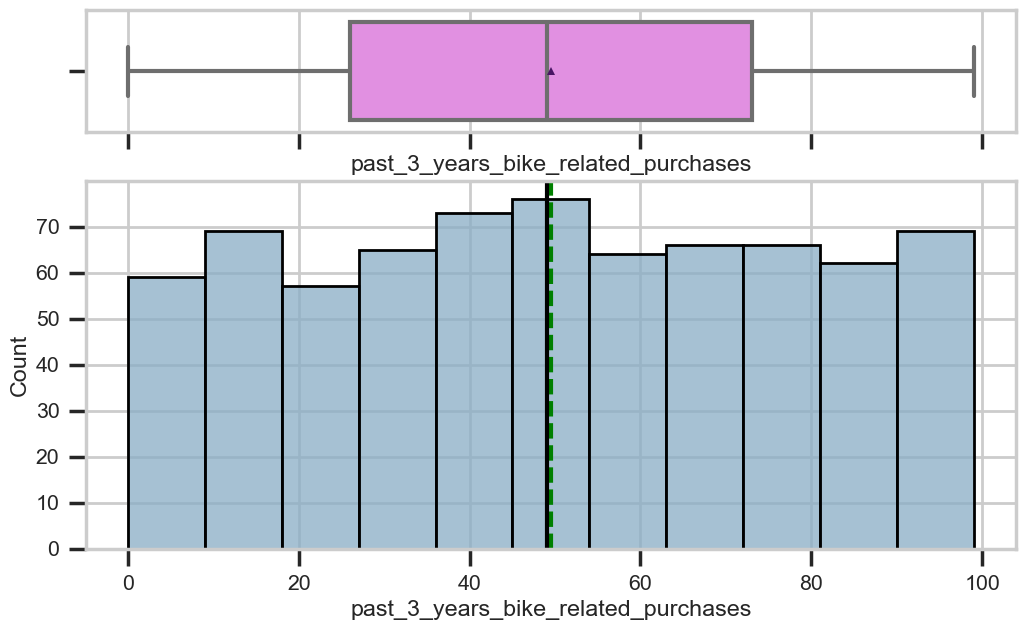

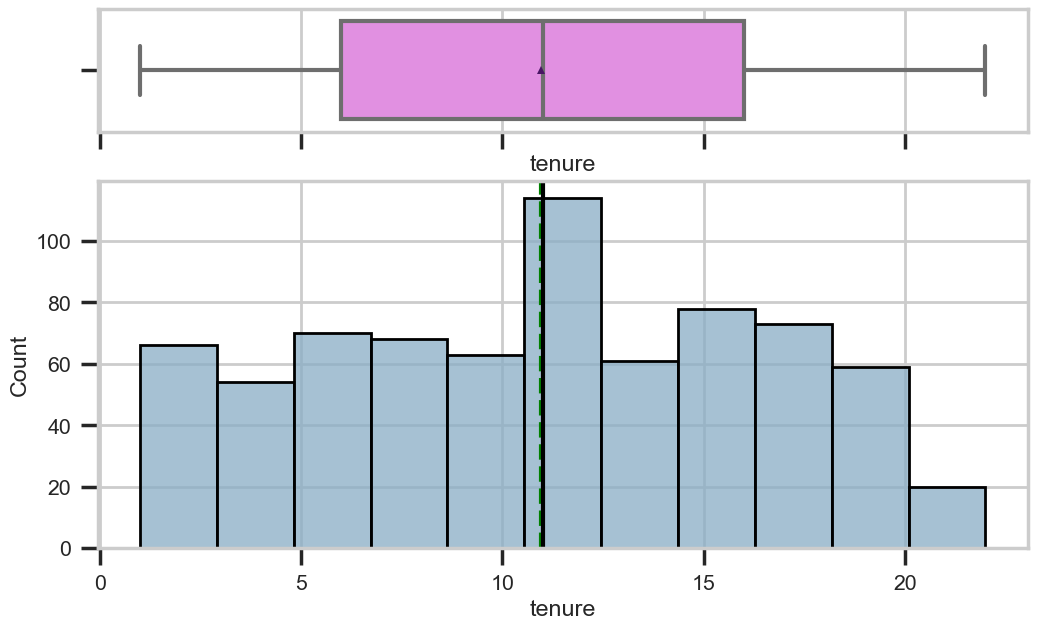

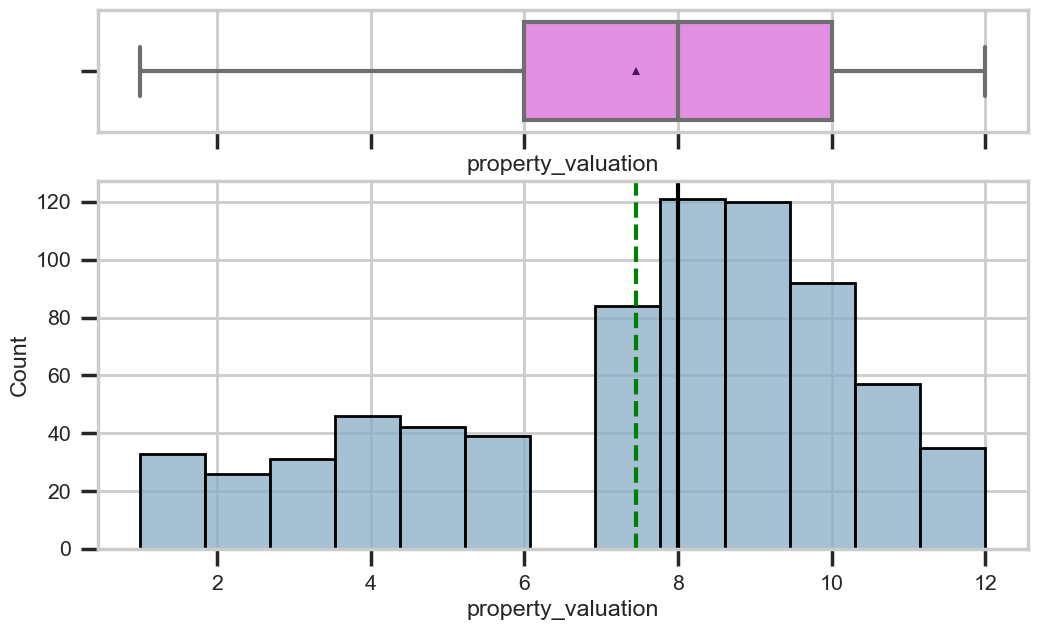

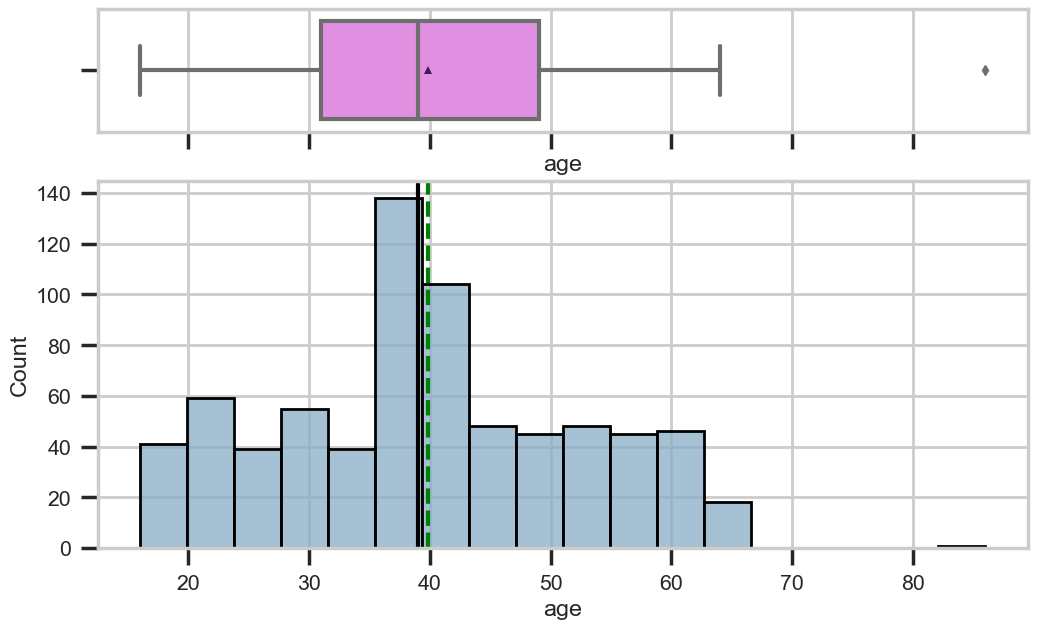

In [80]:
histogram_boxplot(high_value_cus, 'past_3_years_bike_related_purchases')
histogram_boxplot(high_value_cus, 'tenure')
histogram_boxplot(high_value_cus, 'property_valuation')
histogram_boxplot(high_value_cus, 'age')

In [81]:
# Function to plot a labeled barplot
def labeled_barplot(data, feature, perc = False, n = None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # Length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize = (count + 1, 5))
    else:
        plt.figure(figsize = (n + 1, 5))

    plt.xticks(rotation = 90, fontsize = 15)
    ax = sns.countplot(
        data = data,
        x = feature,
        palette = "Paired",
        order = data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )                       # Percentage of each class of the category
        else:
            label = p.get_height()  # Count of each level of the category

        x = p.get_x() + p.get_width() / 2  # Width of the plot
        y = p.get_height()                 # Height of the plot

        ax.annotate(
            label,
            (x, y),
            ha = "center",
            va = "center",
            size = 12,
            xytext = (0, 5),
            textcoords = "offset points",
)  # Annotate the percentage

    plt.show()  

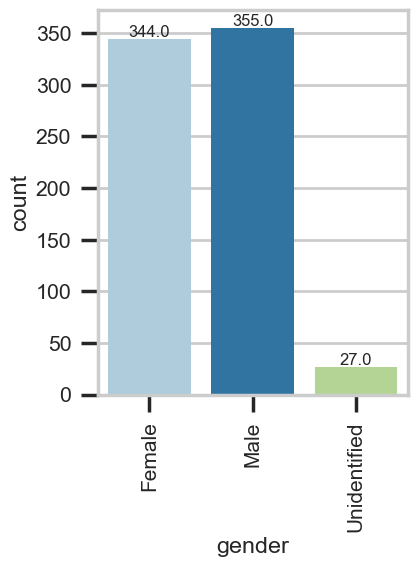

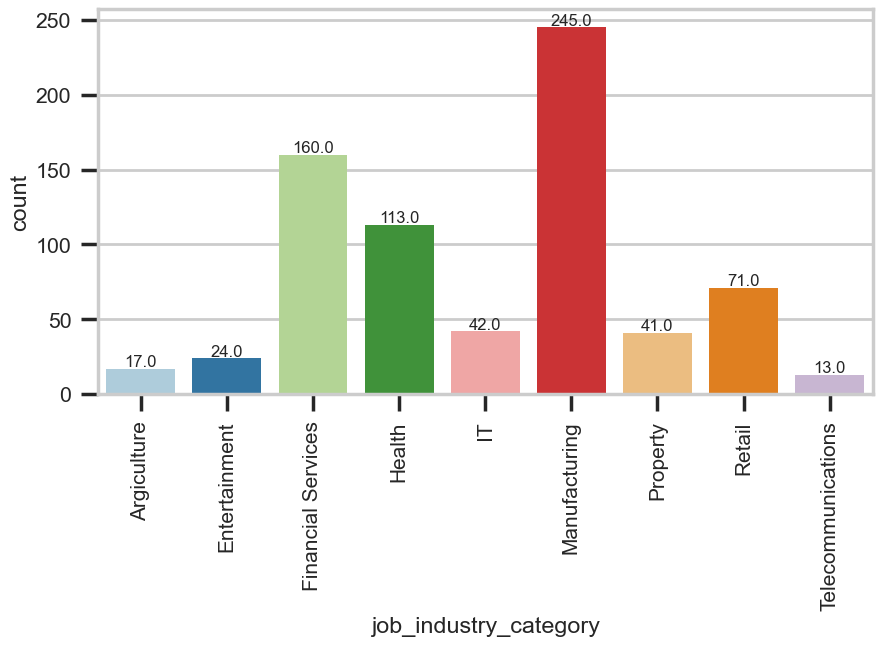

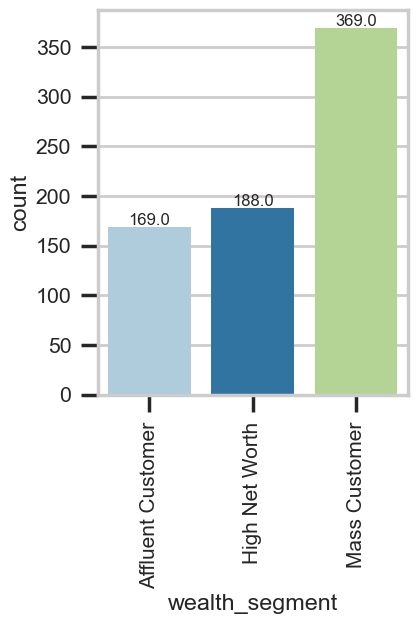

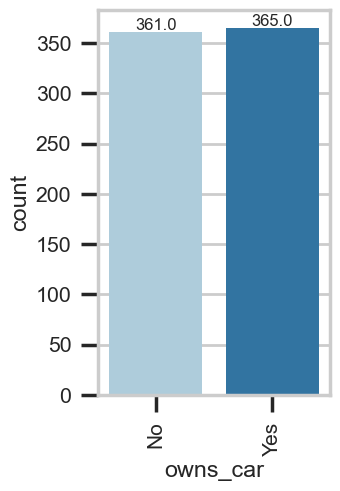

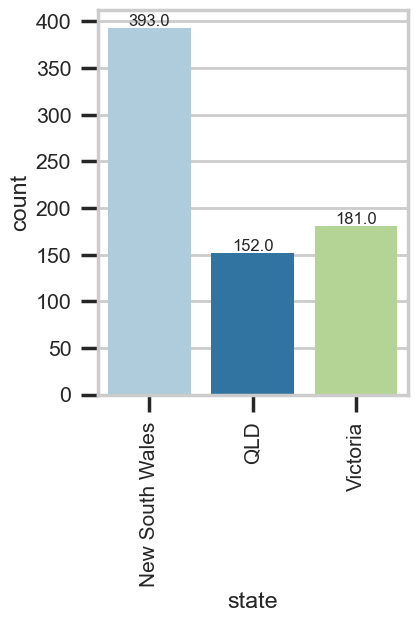

In [82]:
labeled_barplot(high_value_cus, 'gender')
labeled_barplot(high_value_cus, 'job_industry_category')
labeled_barplot(high_value_cus, 'wealth_segment')
labeled_barplot(high_value_cus, 'owns_car')
labeled_barplot(high_value_cus, 'state')

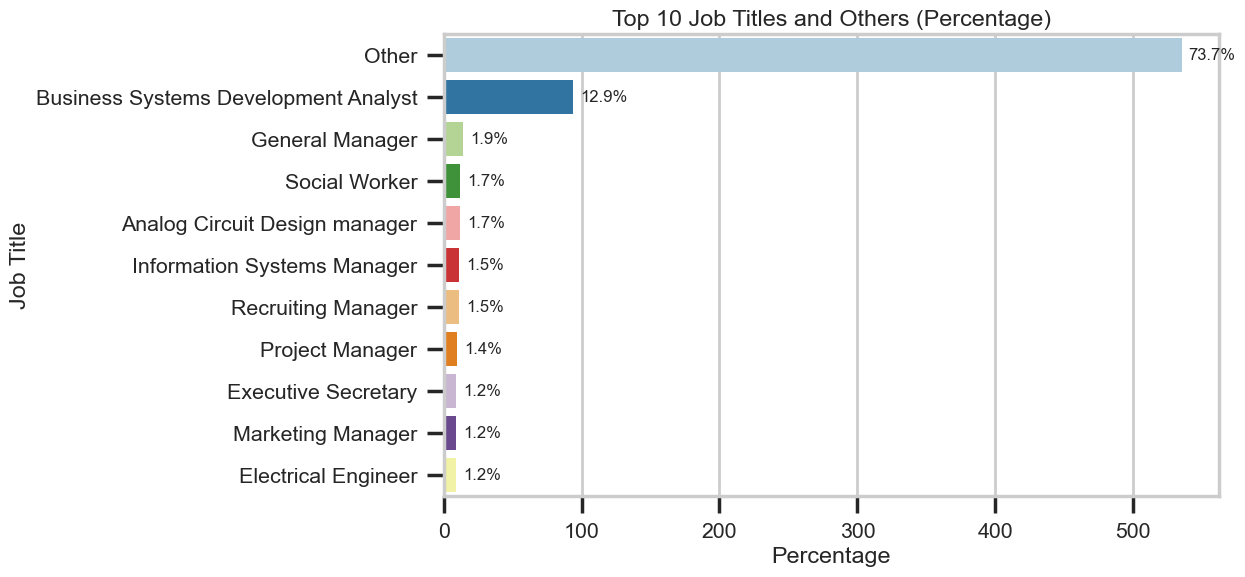

In [83]:
# Select the top N most frequent job titles
top_n = 10
top_job_titles = high_value_cus['job_title'].value_counts().head(top_n).index

# Create a new column where non-top job titles are labeled as 'Other'
high_value_cus['job_title_top'] = high_value_cus['job_title'].where(
    high_value_cus['job_title'].isin(top_job_titles), 'Other'
)

# Calculate the percentage for each category
category_counts = high_value_cus['job_title_top'].value_counts()
total_records = len(high_value_cus)
category_percentages = (category_counts / total_records) * 100

# Create the countplot with percentages
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=high_value_cus, y='job_title_top', order=category_counts.index, palette='Paired')

# Annotate the percentage on top of each bar
for p, percentage in zip(ax.patches, category_percentages):
    ax.annotate(f'{percentage:.1f}%', (p.get_width(), p.get_y() + p.get_height() / 2),
                ha='left', va='center', fontsize=12, xytext=(5, 0), textcoords='offset points')

plt.xlabel('Percentage')
plt.ylabel('Job Title')
plt.title(f'Top {top_n} Job Titles and Others (Percentage)')
plt.show()


## Good Customers

In [84]:
good_cus.describe().T

,count,mean,std,min,25%,50%,75%,max
past_3_years_bike_related_purchases,1510.0,48.892053,28.944445,0.0,23.0,48.0,75.00,99.0
tenure,1510.0,10.559603,5.457598,1.0,6.0,11.0,15.00,22.0
postcode,1510.0,2992.989404,843.276616,2000.0,2203.0,2770.0,3744.25,4879.0
property_valuation,1510.0,7.482119,2.838369,1.0,6.0,8.0,10.00,12.0
age,1510.0,39.951656,12.445706,15.0,31.0,40.0,49.00,74.0
level_map,1510.0,1.000000,0.000000,1.0,1.0,1.0,1.00,1.0


In [85]:

# List of all important categorical variables
cat_col = ["gender", "job_title", 'job_industry_category', 'wealth_segment', 'owns_car', "state"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(good_cus[column].value_counts(1))
    print("-" * 50)

gender
Female          0.507285
Male            0.476159
Unidentified    0.016556
Name: proportion, dtype: float64
--------------------------------------------------
job_title
Business Systems Development Analyst    0.129139
Tax Accountant                          0.014570
Associate Professor                     0.013907
Structural Engineer                     0.013245
Chemical Engineer                       0.013245
                                          ...   
Geologist II                            0.000662
Administrative Assistant I              0.000662
Office Assistant II                     0.000662
Budget/Accounting Analyst II            0.000662
Account Representative II               0.000662
Name: proportion, Length: 190, dtype: float64
--------------------------------------------------
job_industry_category
Manufacturing         0.377483
Financial Services    0.175497
Health                0.158940
Retail                0.084106
Property              0.068874
IT         

#### Visualisation

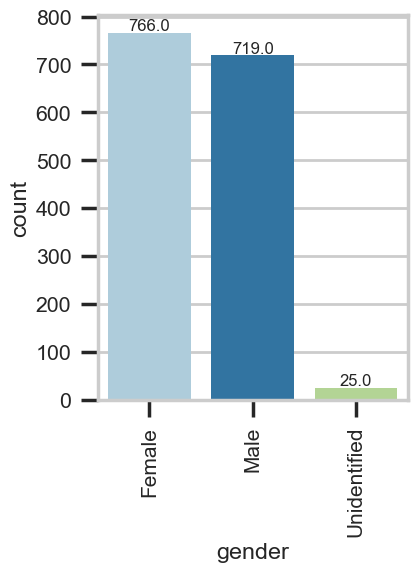

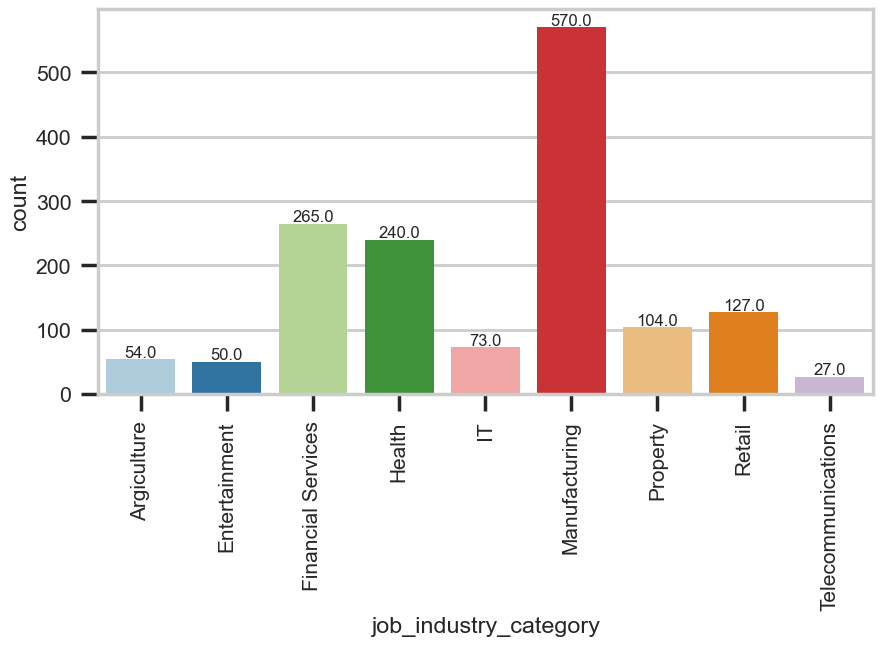

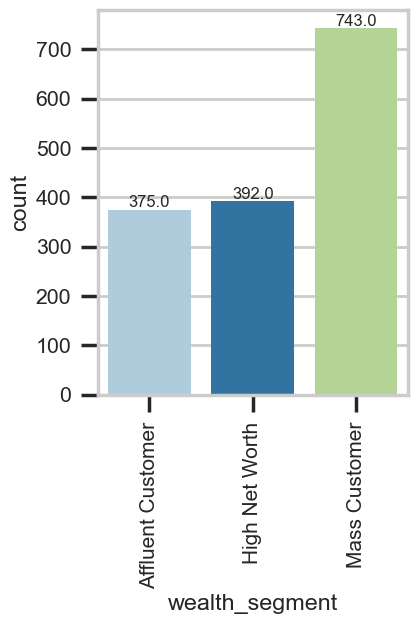

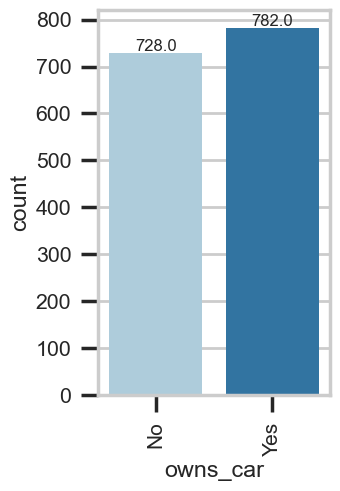

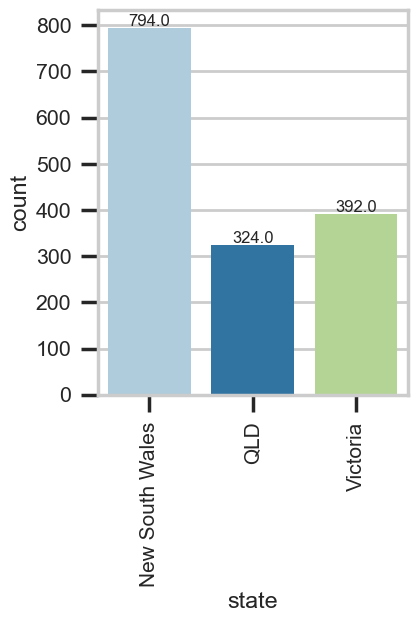

In [86]:
labeled_barplot(good_cus, 'gender')
labeled_barplot(good_cus, 'job_industry_category')
labeled_barplot(good_cus, 'wealth_segment')
labeled_barplot(good_cus, 'owns_car')
labeled_barplot(good_cus, 'state')


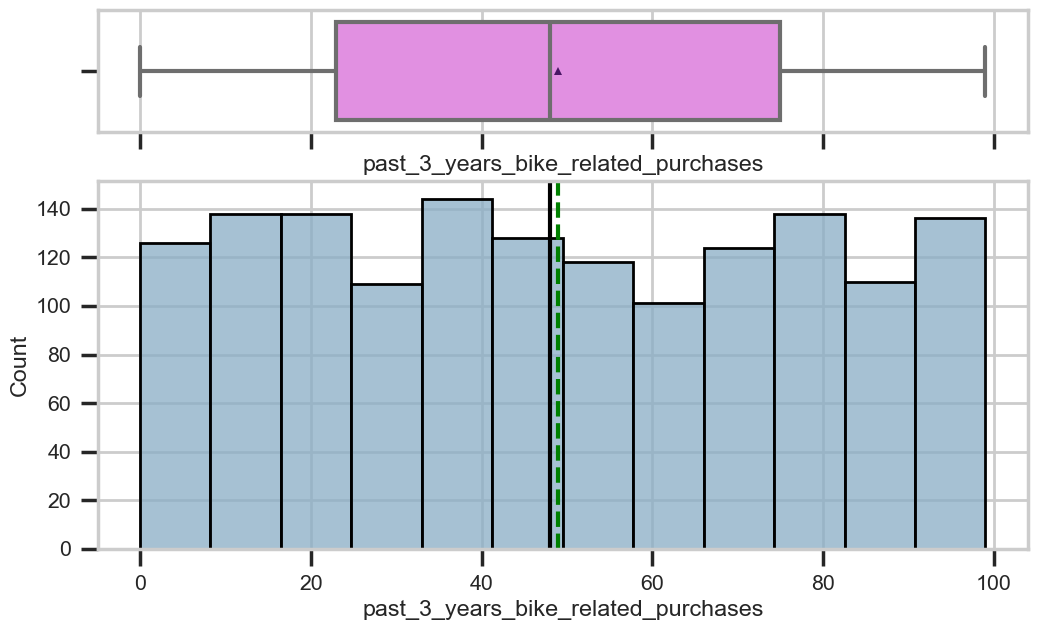

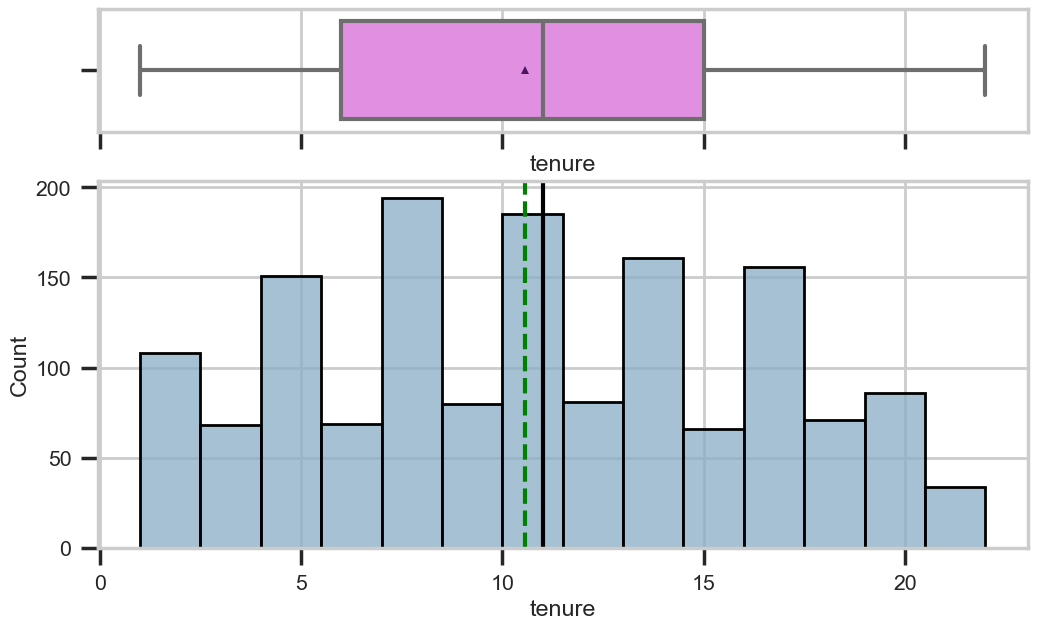

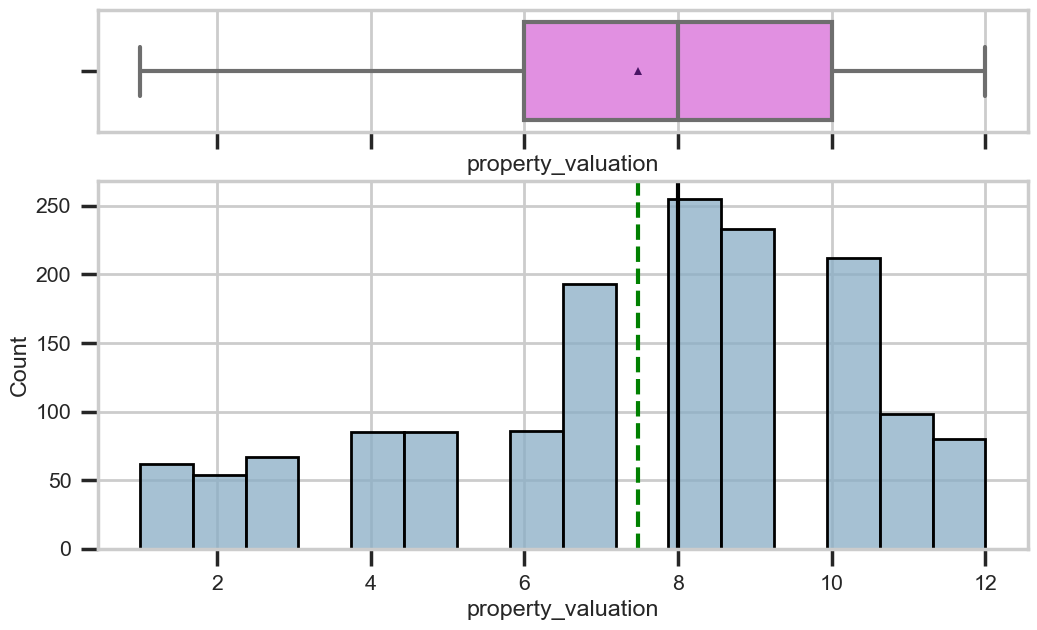

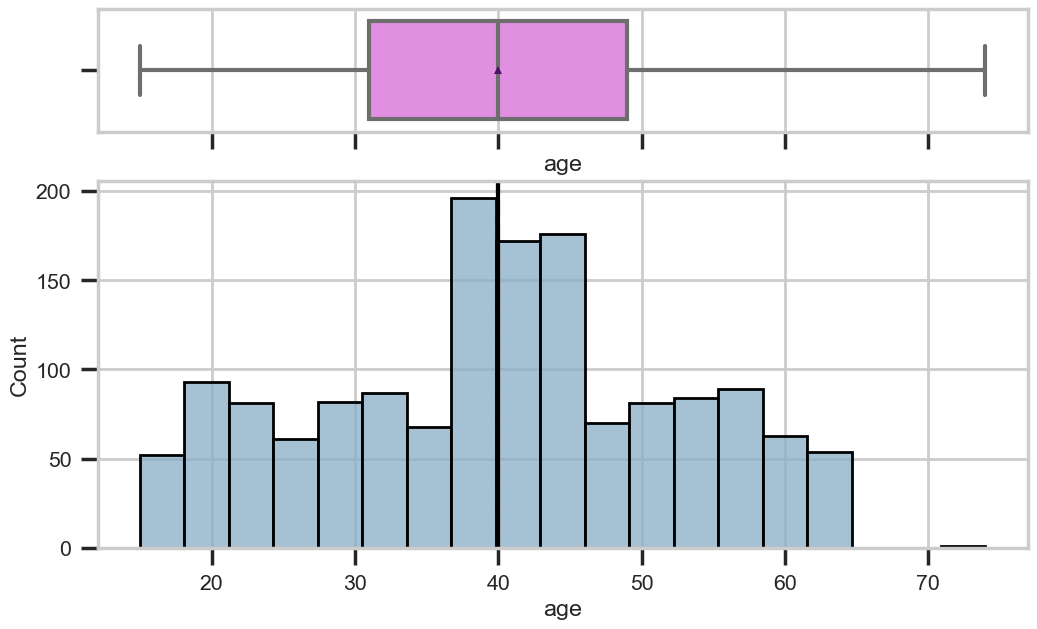

In [87]:
histogram_boxplot(good_cus, 'past_3_years_bike_related_purchases')
histogram_boxplot(good_cus, 'tenure')
histogram_boxplot(good_cus, 'property_valuation')
histogram_boxplot(good_cus, 'age')

## Average Customers

In [88]:
average_cus.describe().T

,count,mean,std,min,25%,50%,75%,max
past_3_years_bike_related_purchases,1051.0,49.095147,28.527255,0.0,24.5,49.0,72.5,99.0
tenure,1051.0,10.705994,5.771040,1.0,6.0,11.0,16.0,22.0
postcode,1051.0,2994.787821,869.006532,2000.0,2196.5,2763.0,3805.0,4879.0
property_valuation,1051.0,7.586108,2.757321,1.0,6.0,8.0,10.0,12.0
age,1051.0,39.686965,12.422791,15.0,30.0,40.0,49.0,82.0
level_map,1051.0,2.000000,0.000000,2.0,2.0,2.0,2.0,2.0


In [89]:
# List of all important categorical variables
cat_col = ["gender", "job_title", 'job_industry_category', 'wealth_segment', 'owns_car', "state"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(average_cus[column].value_counts(1))
    print("-" * 50)

gender
Female          0.517602
Male            0.462417
Unidentified    0.019981
Name: proportion, dtype: float64
--------------------------------------------------
job_title
Business Systems Development Analyst    0.135109
Senior Developer                        0.013321
Electrical Engineer                     0.013321
Legal Assistant                         0.013321
Desktop Support Technician              0.012369
                                          ...   
Office Assistant III                    0.000951
Health Coach IV                         0.000951
Budget/Accounting Analyst III           0.000951
Accountant I                            0.000951
Office Assistant IV                     0.000951
Name: proportion, Length: 179, dtype: float64
--------------------------------------------------
job_industry_category
Manufacturing         0.358706
Financial Services    0.204567
Health                0.138915
Retail                0.083730
Property              0.074215
IT         

#### Data visualization

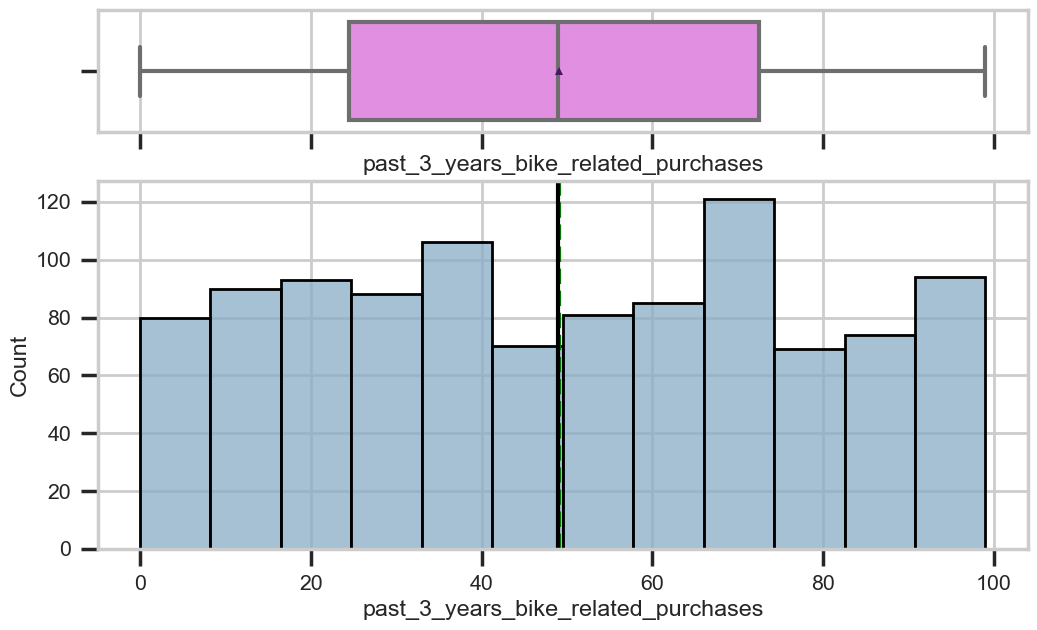

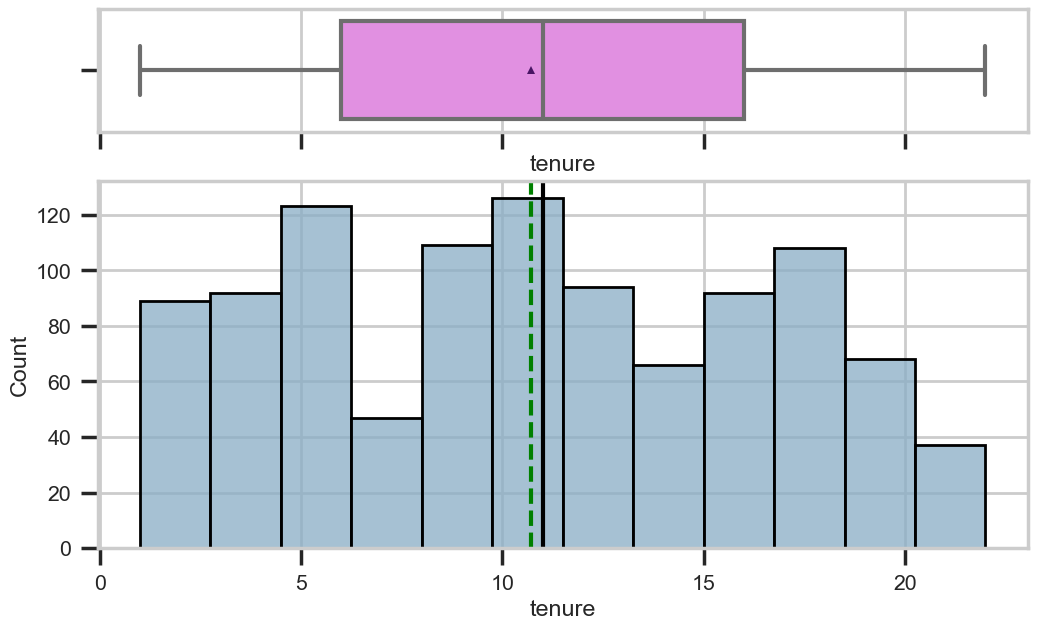

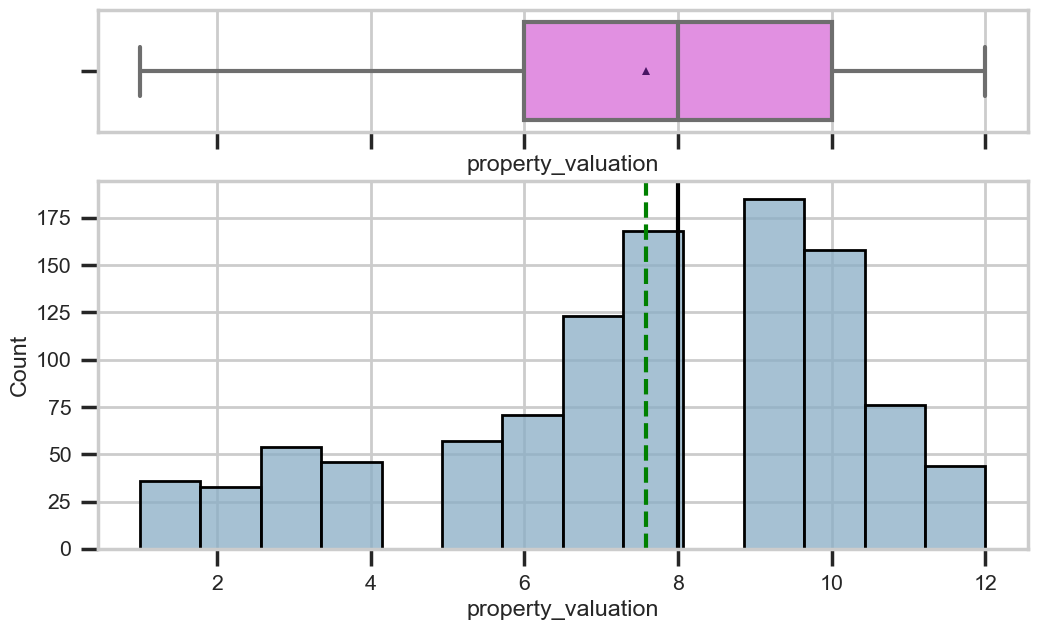

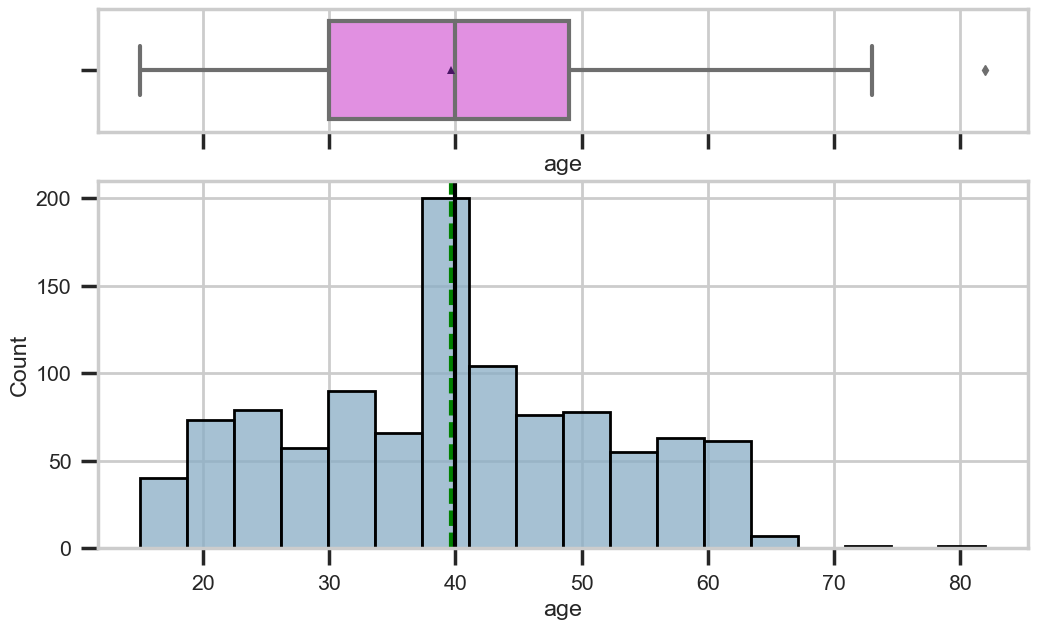

In [90]:
histogram_boxplot(average_cus, 'past_3_years_bike_related_purchases')
histogram_boxplot(average_cus, 'tenure')
histogram_boxplot(average_cus, 'property_valuation')
histogram_boxplot(average_cus, 'age')
   

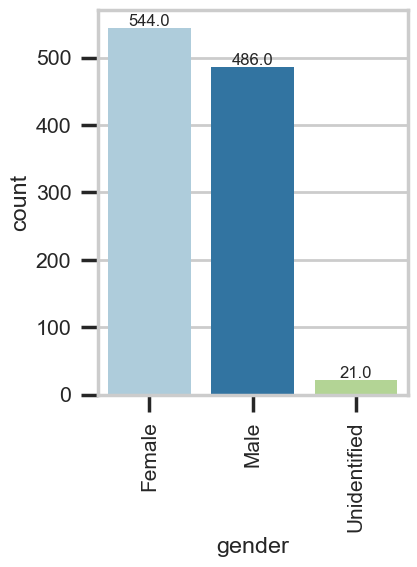

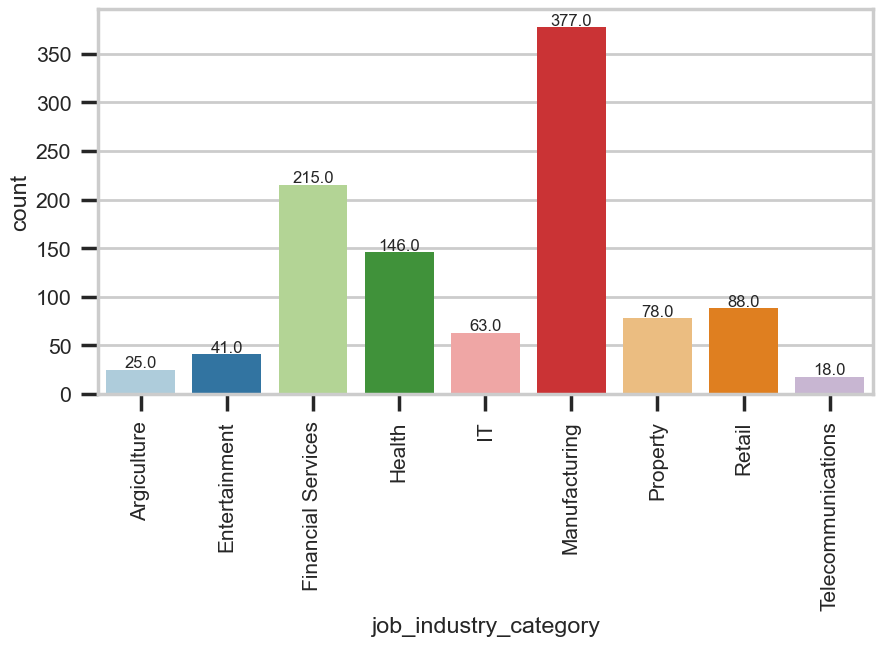

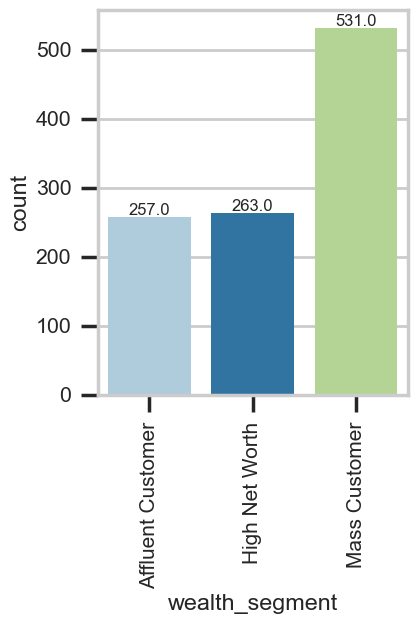

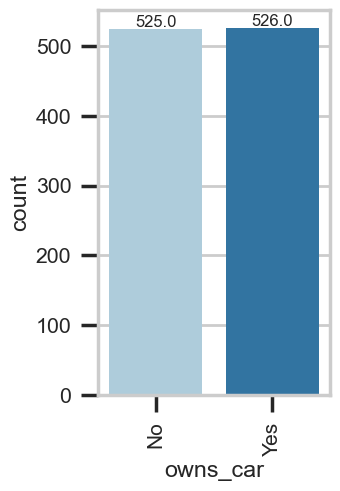

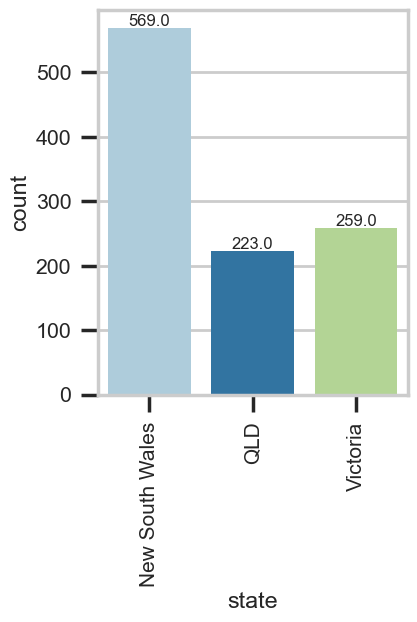

In [94]:
labeled_barplot(average_cus, 'gender')
labeled_barplot(average_cus, 'job_industry_category')
labeled_barplot(average_cus, 'wealth_segment')
labeled_barplot(average_cus, 'owns_car')
labeled_barplot(average_cus, 'state')

## Inactive customers

In [91]:
inactive_cus.describe().T

,count,mean,std,min,25%,50%,75%,max
past_3_years_bike_related_purchases,197.0,43.355330,26.997839,0.0,23.0,39.0,65.0,99.0
tenure,197.0,10.649746,5.498995,1.0,6.0,11.0,15.0,22.0
postcode,197.0,2980.817259,854.925016,2010.0,2191.0,2768.0,3804.0,4878.0
property_valuation,197.0,7.604061,2.852779,1.0,6.0,8.0,10.0,12.0
age,197.0,39.228426,12.302879,16.0,30.0,39.0,46.0,77.0
level_map,197.0,3.000000,0.000000,3.0,3.0,3.0,3.0,3.0


In [92]:
# List of all important categorical variables
cat_col = ["gender", "job_title", 'job_industry_category', 'wealth_segment', 'owns_car', "state"]

# Printing the number of occurrences of each unique value in each categorical column
for column in cat_col:
    print(inactive_cus[column].value_counts(1))
    print("-" * 50)

gender
Female          0.512690
Male            0.472081
Unidentified    0.015228
Name: proportion, dtype: float64
--------------------------------------------------
job_title
Business Systems Development Analyst    0.152284
Registered Nurse                        0.030457
Tax Accountant                          0.020305
Engineer IV                             0.015228
Food Chemist                            0.015228
                                          ...   
Geologist IV                            0.005076
Research Nurse                          0.005076
Financial Advisor                       0.005076
Software Test Engineer II               0.005076
Marketing Assistant                     0.005076
Name: proportion, Length: 107, dtype: float64
--------------------------------------------------
job_industry_category
Manufacturing         0.355330
Financial Services    0.228426
Health                0.167513
Retail                0.081218
IT                    0.045685
Entertainme

#### Data visualization

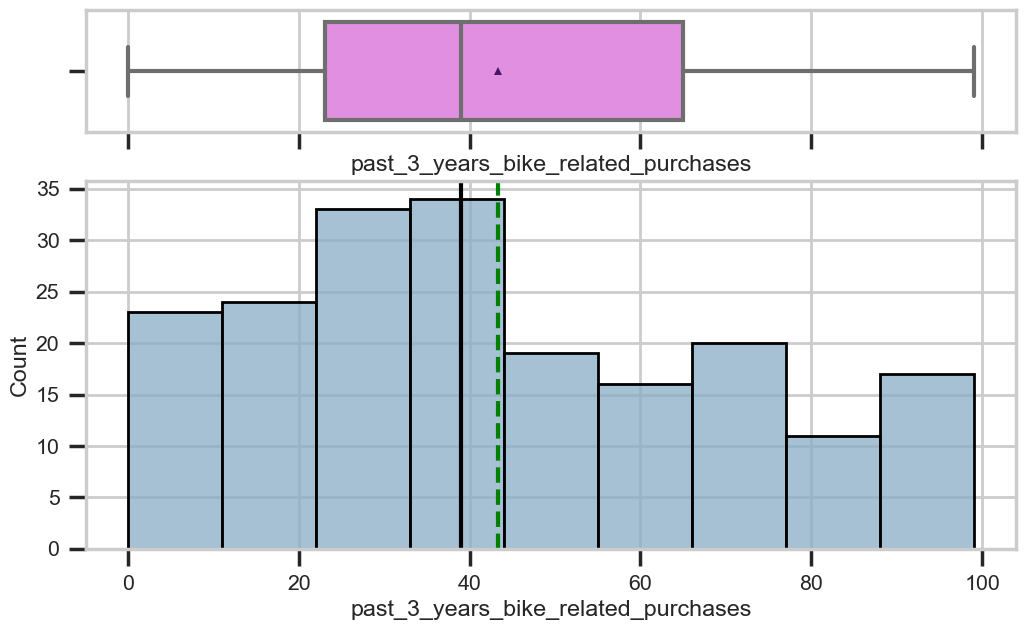

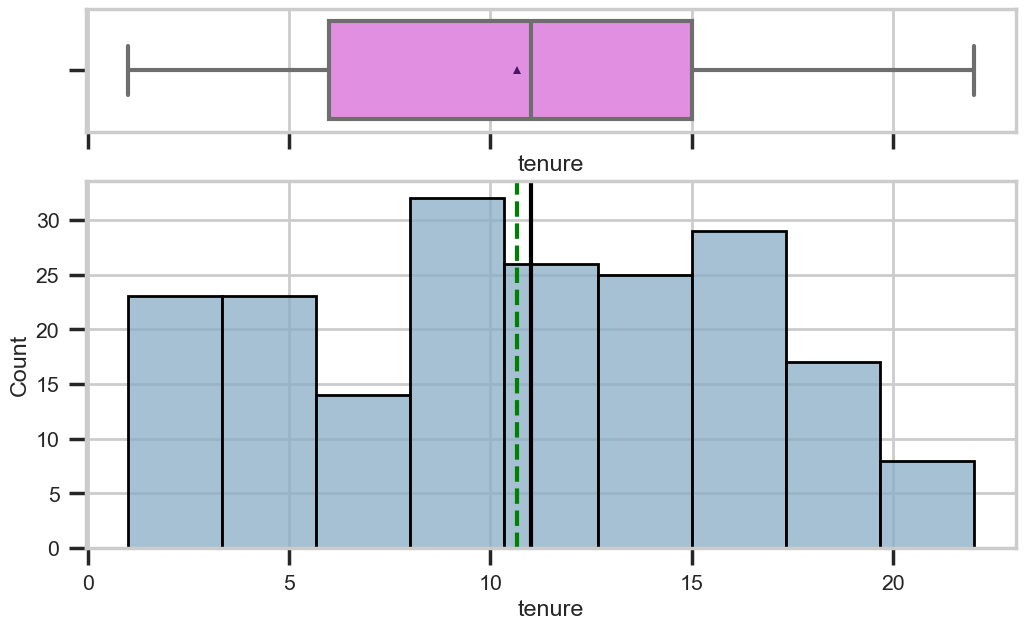

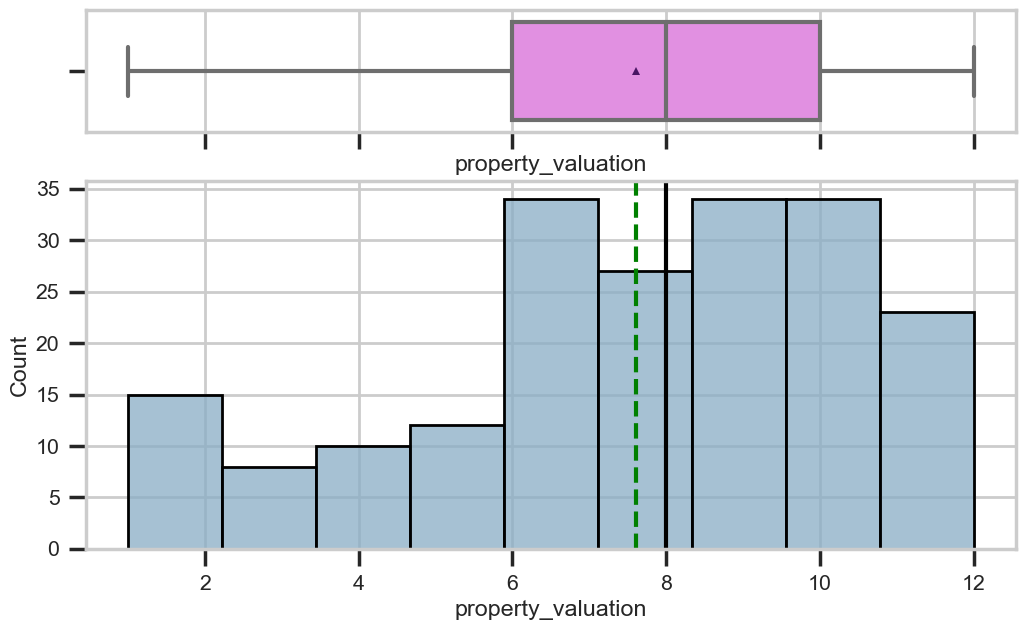

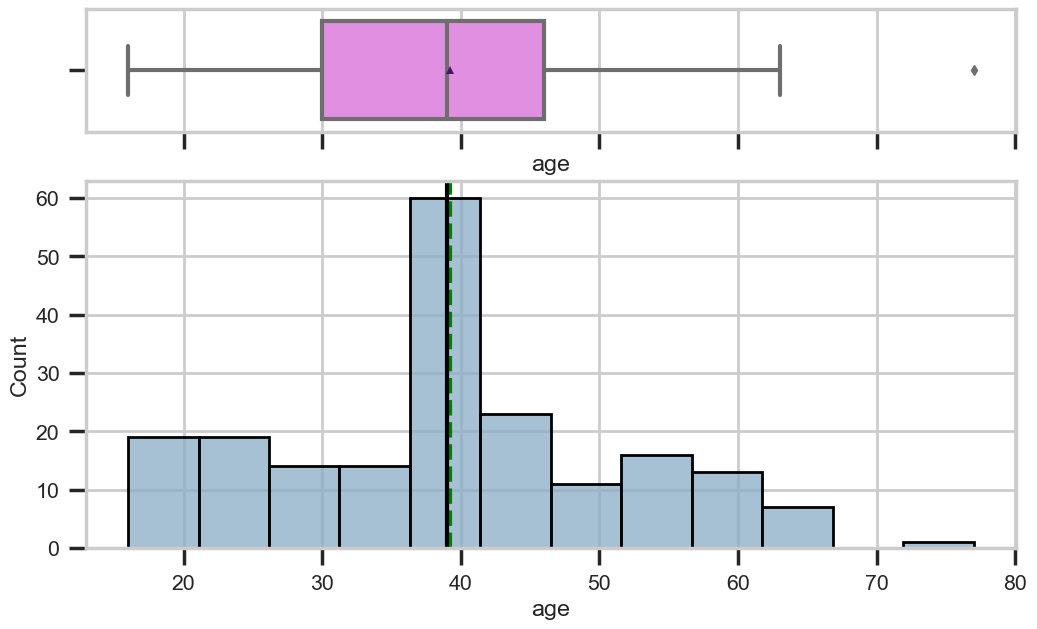

In [93]:
histogram_boxplot(inactive_cus, 'past_3_years_bike_related_purchases')
histogram_boxplot(inactive_cus, 'tenure')
histogram_boxplot(inactive_cus, 'property_valuation')
histogram_boxplot(inactive_cus, 'age')
   

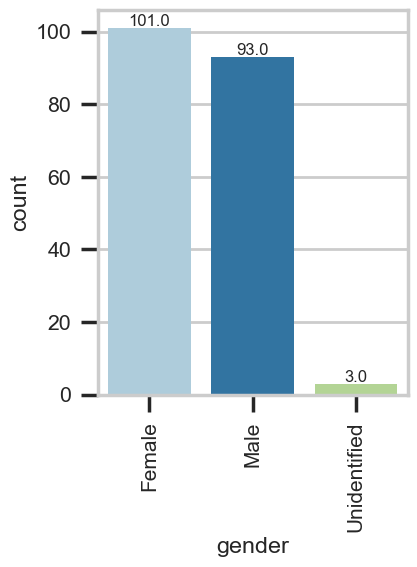

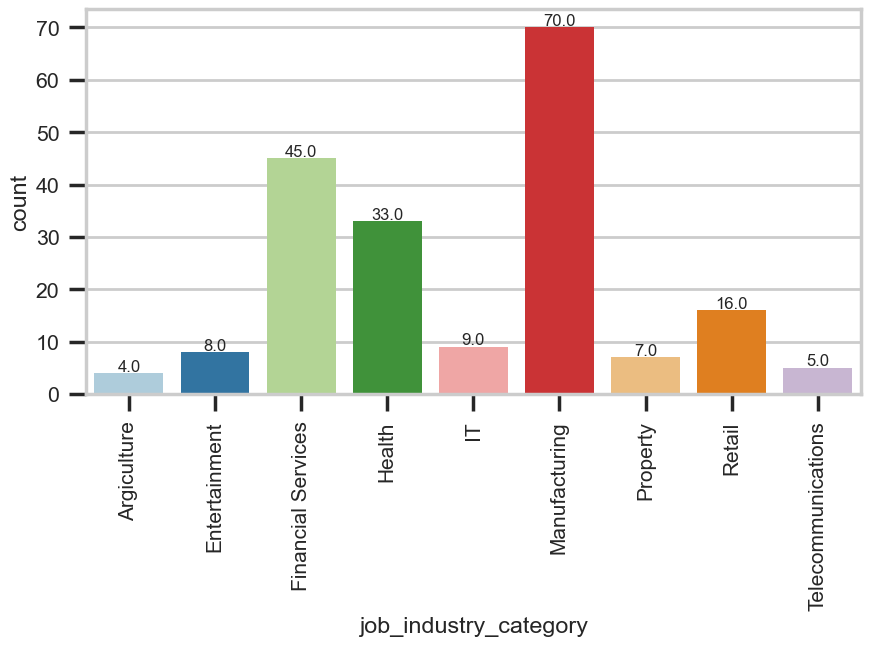

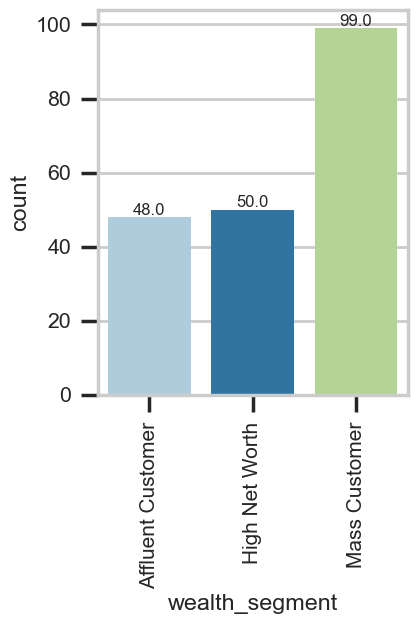

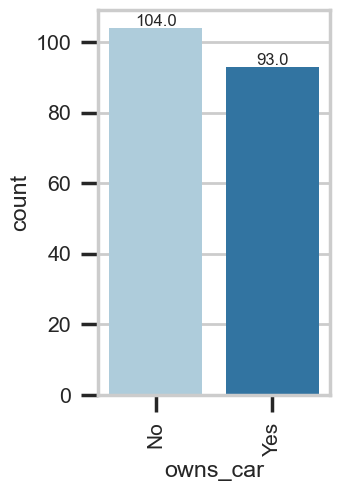

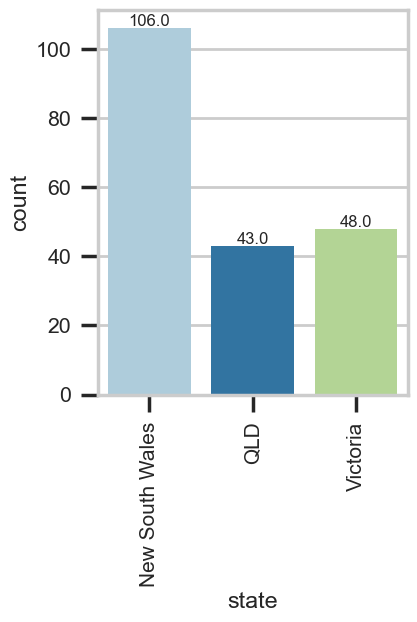

In [95]:
labeled_barplot(inactive_cus, 'gender')
labeled_barplot(inactive_cus, 'job_industry_category')
labeled_barplot(inactive_cus, 'wealth_segment')
labeled_barplot(inactive_cus, 'owns_car')
labeled_barplot(inactive_cus, 'state')

### Conclussions

* The company should focus on the active customers which represent the high valuable customers
* After analysing each cluster customer demographics the following characteristics were found:

Active customers: 
* They have spent an average of 1.19k dollars in Sprocket Central.
* They have an average of 60 bikes related purchases in the past 3 years
* Most of them are between 30 to 50 years old. (Highest: 30-40)
* Job industries: Most of them come from the manufacturing and financial services
* They tend to be Mass and High Network customers
* Most of them come from NSW and Victoria
* Gender distribution is fairly balanced, with a slight male predominance

Good customers:
* They have spent an average of 1.10k dollars. 
* They have an average of 49 bikes related purchases in the past 3 years
* Most of them are between 30 to 60 years old. (Highest: 40-50)
* Job industries: Most of them come from the manufacturing, financial services and health job industries
* Most of them come from NSW and Victoria

Average customers:
* They have spent an average of 993 dollars. 
* They have an average of 50 bikes related purchases in the past 3 years
* Most of them are between 20 to 50 years old. (Highest: 40-50)
* Job industries: Most of them come from the manufacturing and financial services job industries 
* Most of them come from NSW and Victoria

Inactive customers:
* They have spent an average of 803 dollars. 
* They are in majority female
* They have an average of 41 bikes related purchases in the past 3 years
* Most of them are between 40 to 50 years old (Highest: 40-50)
* Most of them come from the manufacturing and financial services job industries
* Job industries: They tend to be Mass and High Network customers
* Most of them come from NSW, and the rest come slighly evenly from Victoria and QLD
* Gender distribution is fairly balanced, with a moderate female predominance

### Recommendations

- Target Both Genders: Develop marketing campaigns that target both genders, but consider a slight emphasis on male-focused campaigns since they represent a slightly larger customer segment.

- Prioritize Past Bike Purchasers: Focus your marketing efforts on customers who have a history of purchasing bikes related products. Implement strategies to retain these customers and encourage repeat purchases.

- Leverage Job Industries: Create tailored marketing campaigns for customers working in manufacturing, financial services, and health job industries. Highlight how your products align with their needs and preferences.

- Expand Geographic Reach: Expand your market presence beyond NSW to tap into new customer bases. Consider opportunities to expand stores in Victoria as it has the second highest number of customers in the high value customers segment.

- Age-Targeted Marketing: Customize marketing initiatives to appeal to different age groups. Prioritize customers aged 30-40 as your primary demographic, followed by those aged 40-50. Craft messaging and promotions that resonate with these age brackets.

By implementing these recommendations, you can maximize your marketing efforts to reach the right audience, increase customer engagement, and drive business growth effectively.

